<a href="https://colab.research.google.com/github/mansiraturi/RFM_Analysis/blob/main/RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Customer Segmentation using RFM Analysis**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

import sklearn.linear_model as skl_lm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import train_test_split

**Data Acquisition**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [190]:
customer= pd.read_csv('/content/drive/MyDrive/proj2/dataset.csv',  encoding='ISO-8859-1' )

**Data Inspection**

In [191]:
customer.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [192]:
customer.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [193]:
customer.describe(include="object")

InvoiceNo StockCode                         Description  \
count     541909    541909                              540455   
unique     25900      4070                                4223   
top       573585    85123A  WHITE HANGING HEART T-LIGHT HOLDER   
freq        1114      2313                                2369   

             InvoiceDate         Country  
count             541909          541909  
unique             23260              38  
top     10/31/2011 14:41  United Kingdom  
freq                1114          495478

**1. DATA PREPROCESSING**

In [194]:
print("customer dataset has ", customer.shape[0], "rows")
print("customer dataset has ", customer.shape[1], "features")

customer dataset has  541909 rows
customer dataset has  8 features


In [195]:
customer.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Converting column values to appropriate datatypes

In [196]:
import re
# Convert the date and time columns to date-time datatype
customer['InvoiceDate'] = pd.to_datetime(customer['InvoiceDate'], format='%m/%d/%Y %H:%M')
#customer['CustomerID'] = customer['CustomerID'].astype(int)

In [197]:
cat_ft = [ft for ft in customer.columns if  customer[ft].dtypes== 'object' ]
print("There are", len(cat_ft), "categorical features")
print("The categorical features are:", cat_ft)

There are 4 categorical features
The categorical features are: ['InvoiceNo', 'StockCode', 'Description', 'Country']


In [198]:
num_ft = [ft for ft in customer.columns if  customer[ft].dtypes!= 'object' and  customer[ft].dtypes!= 'datetime64[ns]']
print("There are", len(num_ft), "numerical features")
print("The categorical features are:", num_ft)

There are 3 numerical features
The categorical features are: ['Quantity', 'UnitPrice', 'CustomerID']


Handling Missing Data

In [199]:
missing_val = [ft for ft in customer.columns if customer[ft].isnull().sum()>1]
print("There are ", len(missing_val) , "columns with missing values")
print()
for ft in missing_val:
    print(ft, np.round(customer[ft].isnull().mean(), 3)*100, "%")

There are  2 columns with missing values

Description 0.3 %
CustomerID 24.9 %


<Axes: >

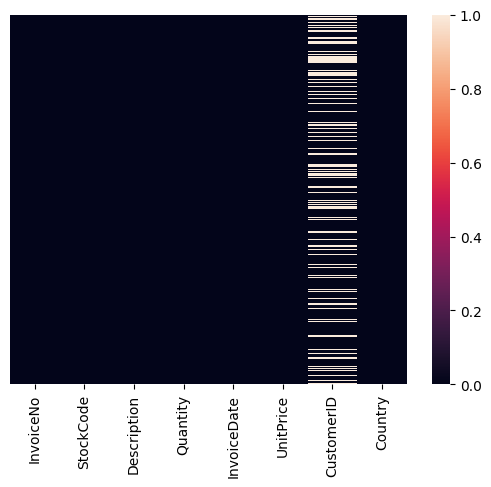

In [200]:
sns.heatmap(customer.isnull(), yticklabels= False)

In [201]:
#filling null values
customer['Description'] = customer['Description'].fillna('Unknown')
customer['CustomerID']  = customer['CustomerID'].fillna(0)

**Removing Dupilcates**

In [202]:
duplicates = customer[customer.duplicated(keep=False)]
duplicate_rows_sorted = duplicates.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])
duplicate_rows_sorted.head(10)

InvoiceNo StockCode                       Description  Quantity  \
494    536409     21866       UNION JACK FLAG LUGGAGE TAG         1   
517    536409     21866       UNION JACK FLAG LUGGAGE TAG         1   
485    536409     22111      SCOTTIE DOG HOT WATER BOTTLE         1   
539    536409     22111      SCOTTIE DOG HOT WATER BOTTLE         1   
489    536409     22866     HAND WARMER SCOTTY DOG DESIGN         1   
527    536409     22866     HAND WARMER SCOTTY DOG DESIGN         1   
521    536409     22900   SET 2 TEA TOWELS I LOVE LONDON          1   
537    536409     22900   SET 2 TEA TOWELS I LOVE LONDON          1   
578    536412     21448         12 DAISY PEGS IN WOOD BOX         1   
598    536412     21448         12 DAISY PEGS IN WOOD BOX         1   

            InvoiceDate  UnitPrice  CustomerID         Country  
494 2010-12-01 11:45:00       1.25     17908.0  United Kingdom  
517 2010-12-01 11:45:00       1.25     17908.0  United Kingdom  
485 2010-12-01 11:45:00       4.95     17908.0  United Kingdom  
539 2010-12-01 11:45:00       4.95     17908.0  United Kingdom  
489 2010-12-01 11:45:00       2.10     17908.0  United Kingdom  
527 2010-12-01 11:45:00       2.10     17908.0  United Kingdom  
521 2010-12-01 11:45:00       2.95     17908.0  United Kingdom  
537 2010-12-01 11:45:00       2.95     17908.0  United Kingdom  
578 2010-12-01 11:49:00       1.65     17920.0  United Kingdom  
598 2010-12-01 11:49:00       1.65     17920.0  United Kingdom

In [203]:
# Displaying the number of duplicate rows
print(f"The dataset contains {customer.duplicated().sum()} duplicate rows that need to be eliminated.")

The dataset contains 5268 duplicate rows that need to be eliminated.


In [204]:
#Eliminating duplicates
customer = customer.drop_duplicates()
customer.shape

(536641, 8)

**Handling negative features**

In [205]:
neg_ft = [ft for ft in num_ft if (customer[ft] < 0).any()]
for ft in neg_ft:
    sum_cust = len(customer[customer[ft] < 0])
    print(f"There are {sum_cust} negative quantities for feature '{ft}'")

There are 10587 negative quantities for feature 'Quantity'
There are 2 negative quantities for feature 'UnitPrice'


In [206]:
return_order = customer[customer['Quantity'] < 0]
print("There are ", round(len(return_order)/len(customer),2)*100, "% negative quantities which imply that these orders were either cancelled or returned")

There are  2.0 % negative quantities which imply that these orders were either cancelled or returned


In [207]:
#convertign unit price to positive
customer.loc[:, 'UnitPrice'] = customer['UnitPrice'].abs()

In [ ]:
pd.options.mode.chained_assignment = None

**2. RFM CALCULATION**

In [208]:
customer['Total Price'] = customer['UnitPrice']*customer['Quantity']
customer.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Total Price  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom        15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom        22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34

In [209]:
negative_price = customer[customer['Total Price'] < 0]
negative_price.head()

InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice  CustomerID         Country  Total Price  
141 2010-12-01 09:41:00      27.50     14527.0  United Kingdom       -27.50  
154 2010-12-01 09:49:00       4.65     15311.0  United Kingdom        -4.65  
235 2010-12-01 10:24:00       1.65     17548.0  United Kingdom       -19.80  
236 2010-12-01 10:24:00       0.29     17548.0  United Kingdom        -6.96  
237 2010-12-01 10:24:00       0.29     17548.0  United Kingdom        -6.96

In [ ]:
# customer = customer[customer['Total Price'] >= 0]

In [210]:
customer.shape

(536641, 9)

In [211]:
#Store values with CustomerID =  0 in another dataframe
unknown_cust = customer[customer['CustomerID'] == 0]
customer = customer[customer['CustomerID'] != 0]

In [212]:
#Recency
# Define a function to extract the date part
def extract_date_max(series):
    return series.dt.date.max()

current_date = customer['InvoiceDate'].dt.date.max()
recency_data = customer.groupby('CustomerID')['InvoiceDate'].apply(extract_date_max).reset_index()
recency_data['Recency'] = (current_date - recency_data['InvoiceDate']).dt.days
recency_data.drop('InvoiceDate', axis=1, inplace=True)
print(recency_data.head())

   CustomerID  Recency
0     12346.0      325
1     12347.0        2
2     12348.0       75
3     12349.0       18
4     12350.0      310


In [213]:
current_date

datetime.date(2011, 12, 9)

In [214]:
# Frequency (F) without using lambda
frequency_data = customer.groupby('CustomerID').agg({'InvoiceNo': 'size'})
frequency_data.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)
frequency_data.head()


Frequency
CustomerID           
12346.0             2
12347.0           182
12348.0            31
12349.0            73
12350.0            17

This is the distribution of number of orders per customers

In [215]:
# Monetary (M)
monetary_df = customer.groupby('CustomerID')['Total Price'].sum().reset_index()
monetary_df.rename(columns={'Total Price': 'Monetary'}, inplace=True)
print(monetary_df.head())

   CustomerID  Monetary
0     12346.0      0.00
1     12347.0   4310.00
2     12348.0   1797.24
3     12349.0   1757.55
4     12350.0    334.40


In [263]:
# Merge Recency, Frequency, and Monetary metrics into a single DataFrame
rfm_df = pd.merge(recency_data[['CustomerID', 'Recency']], frequency_data, on='CustomerID')
rfm_df = pd.merge(rfm_df, monetary_df, on='CustomerID')
rfm_df.head()

CustomerID  Recency  Frequency  Monetary
0     12346.0      325          2      0.00
1     12347.0        2        182   4310.00
2     12348.0       75         31   1797.24
3     12349.0       18         73   1757.55
4     12350.0      310         17    334.40

In [265]:
rfm_df['Monetary'] = rfm_df['Monetary'].astype(int)

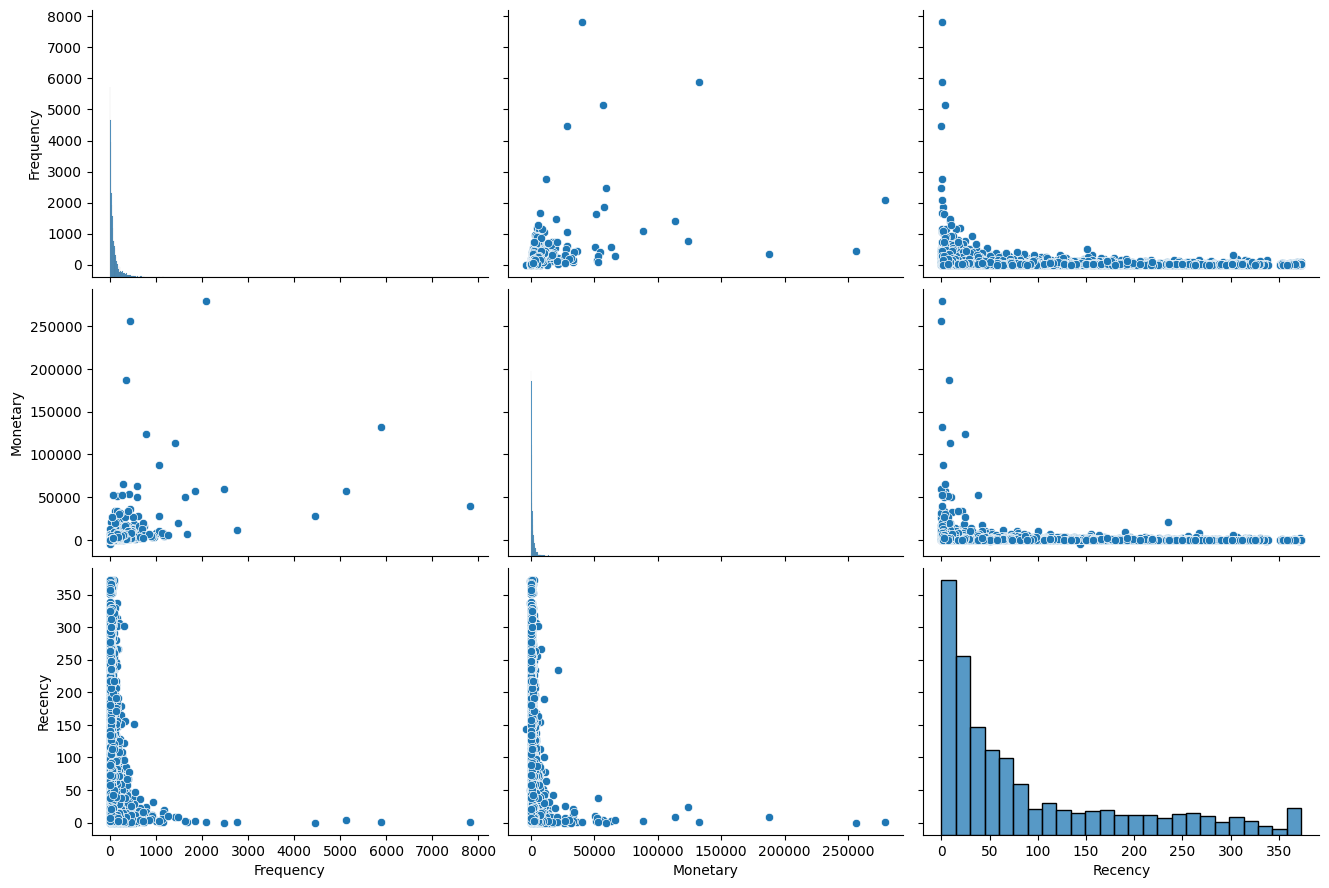

In [218]:
columns = ['Frequency', 'Monetary', 'Recency']
sns.pairplot(rfm_df[columns], height=3, aspect=1.5)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


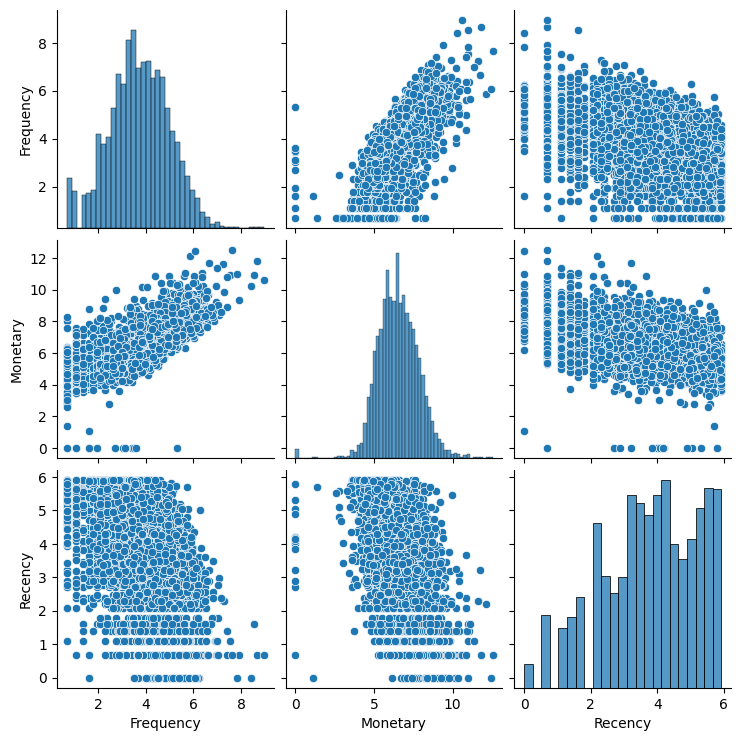

In [272]:
rfm_copy= rfm_df.copy()
rfm_copy['Recency'] = np.log(rfm_copy['Recency']+1)
rfm_copy['Frequency'] = np.log(rfm_copy['Frequency']+1)
rfm_copy['Monetary'] = np.log(rfm_copy['Monetary']+1)
sns.pairplot(rfm_copy[columns])

In [273]:
rfm_copy.head()

CustomerID   Recency  Frequency  Monetary
0     12346.0  5.786897   1.098612  0.000000
1     12347.0  1.098612   5.209486  8.368925
2     12348.0  4.330733   3.465736  7.494430
3     12349.0  2.944439   4.304065  7.471932
4     12350.0  5.739793   2.890372  5.814131

In [266]:
rfm_copy[rfm_copy['Monetary']==rfm_copy['Monetary'].max()]

CustomerID   Recency  Frequency   Monetary
1703     14646.0  0.693147   7.643004  12.540722

In [274]:
if rfm_copy['Monetary'].isin([np.nan, np.inf, -np.inf]).any().any():
    rfm_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
    max_values = rfm_copy['Monetary'].max()  # Calculate the maximum value for each column
    rfm_copy.fillna(max_values, inplace=True)  # Fill NaN values with the maximum value for each column
else:
    print("No NaN or infinite values found.")


In [275]:
if rfm_copy['Recency'].isin([np.nan, np.inf, -np.inf]).any().any():
    rfm_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
    max_values = rfm_copy['Recency'].max()  # Calculate the maximum value for each column
    rfm_copy.fillna(max_values, inplace=True)  # Fill NaN values with the maximum value for each column
else:
    print("No NaN or infinite values found.")


No NaN or infinite values found.


In [276]:
rfm_copy.isna().sum()

CustomerID    0
Recency       0
Frequency     0
Monetary      0
dtype: int64

In [277]:
rfm_copy.dtypes

CustomerID    float64
Recency       float64
Frequency     float64
Monetary      float64
dtype: object

**3. RFM SEGMENTATION**

In [313]:
# On rfm_copy (and then perform log transformation)
quartile = [0, 0.25, 0.5, 0.75, 1]
# Calculate quantiles for Recency, Frequency, and Monetary
recency_quartiles = pd.qcut(rfm_copy['Recency'], q=quartile, labels=False, duplicates='drop')
frequency_quartiles = pd.qcut(rfm_copy['Frequency'], q=quartile, labels=False, duplicates='drop')
monetary_quartiles = pd.qcut(rfm_copy['Monetary'], q=quartile, labels=False, duplicates='drop')

# Assign quartile scores to each customer
rfm_copy['RecencyScore'] = recency_quartiles + 1  # Add 1 to start scores from 1 instead of 0
rfm_copy['FrequencyScore'] = (max(frequency_quartiles) + 1) - frequency_quartiles  # Reverse the frequency scores
rfm_copy['MonetaryScore'] = ((max(monetary_quartiles) + 1) - monetary_quartiles)  # Reverse the monetary scores



rfm_copy['RFMScore'] = rfm_copy['RecencyScore'] * 100 + rfm_copy['FrequencyScore'] * 10 + rfm_copy['MonetaryScore']

rfm_copy.head()


CustomerID   Recency  Frequency  Monetary  RecencyScore  FrequencyScore  \
0     12346.0  5.786897   1.098612  0.000000             4               4   
1     12347.0  1.098612   5.209486  8.368925             1               1   
2     12348.0  4.330733   3.465736  7.494430             3               3   
3     12349.0  2.944439   4.304065  7.471932             2               2   
4     12350.0  5.739793   2.890372  5.814131             4               4   

   MonetaryScore  RFMScore  RFMsum  Cluster  segment  
0              4       444      12        4      444  
1              1       111       3        1      111  
2              1       331       7        2      331  
3              1       221       5        1      221  
4              3       443      11        2      443

In [279]:
rfm_copy['RFMsum'] = rfm_copy[['RecencyScore','FrequencyScore','MonetaryScore']].sum(axis=1)

In [280]:
rfm_copy.head()

CustomerID   Recency  Frequency  Monetary  RecencyScore  FrequencyScore  \
0     12346.0  5.786897   1.098612  0.000000             4               4   
1     12347.0  1.098612   5.209486  8.368925             1               1   
2     12348.0  4.330733   3.465736  7.494430             3               3   
3     12349.0  2.944439   4.304065  7.471932             2               2   
4     12350.0  5.739793   2.890372  5.814131             4               4   

   MonetaryScore  RFMScore  RFMsum  
0              4       444      12  
1              1       111       3  
2              1       331       7  
3              1       221       5  
4              3       443      11

In [ ]:
# rfm_data2 = rfm_df['RFMScore']

**CUSTOMER SEGMENTATION**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

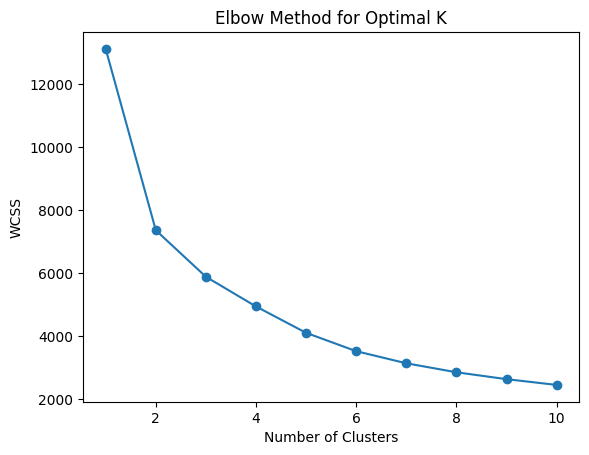

In [281]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select RFM features for clustering
rfm_ft = rfm_copy[['Recency', 'Frequency', 'Monetary']]

scaler = StandardScaler()
rfm_data = scaler.fit_transform(rfm_ft)

# optimal number of clusters using the Elbow Method
wcss = []  # Within-Cluster-Sum-of-Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_data)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  # Within-Cluster-Sum-of-Squares
plt.show()

In [282]:
print(rfm_data)

[[ 1.4289457  -2.09629319 -4.66160351]
 [-1.88947218  1.173006    1.24831606]
 [ 0.39825735 -0.21376515  0.63077023]
 ...
 [-1.19523084 -0.87120678 -1.00633978]
 [-1.68584776  2.26455995  0.72201623]
 [-0.0048643   0.42002912  0.64630824]]


In [284]:
#Silhoutte score
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
import matplotlib.cm as cm

In [285]:
clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(rfm_ft)
print(cluster_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 2 3 ... 0 2 3]


In [286]:
rfm_val = rfm_copy[['CustomerID','Recency', 'Frequency', 'Monetary']]

In [287]:
rfm_val.head()

CustomerID   Recency  Frequency  Monetary
0     12346.0  5.786897   1.098612  0.000000
1     12347.0  1.098612   5.209486  8.368925
2     12348.0  4.330733   3.465736  7.494430
3     12349.0  2.944439   4.304065  7.471932
4     12350.0  5.739793   2.890372  5.814131

In [243]:
rfm_copy.head()

CustomerID  Recency  Frequency  Monetary  RecencyScore  FrequencyScore  \
0       12346        5          1         0             4               4   
1       12347        1          5         8             1               1   
2       12348        4          3         7             3               3   
3       12349        2          4         7             1               2   
4       12350        5          2         5             4               4   

   MonetaryScore  RFMScore  RFMsum  
0              4       444      12  
1              1       111       3  
2              2       332       8  
3              2       122       5  
4              4       444      12

In [288]:
clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(rfm_ft)
print(cluster_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 2 3 ... 0 2 3]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.38889480572630686


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.2954062081018336


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.3068337332926934


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.31673810327440394


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.2815692534071923


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.28431126591889855


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.2682107736808123


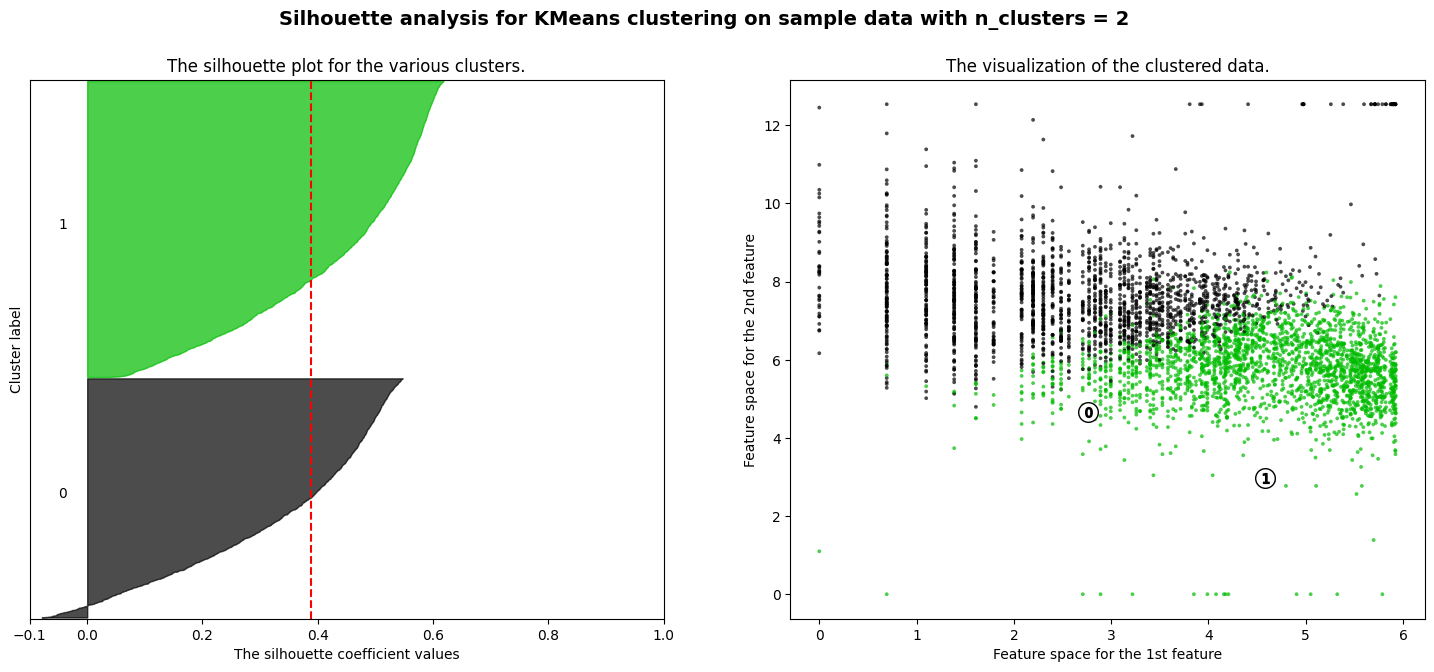

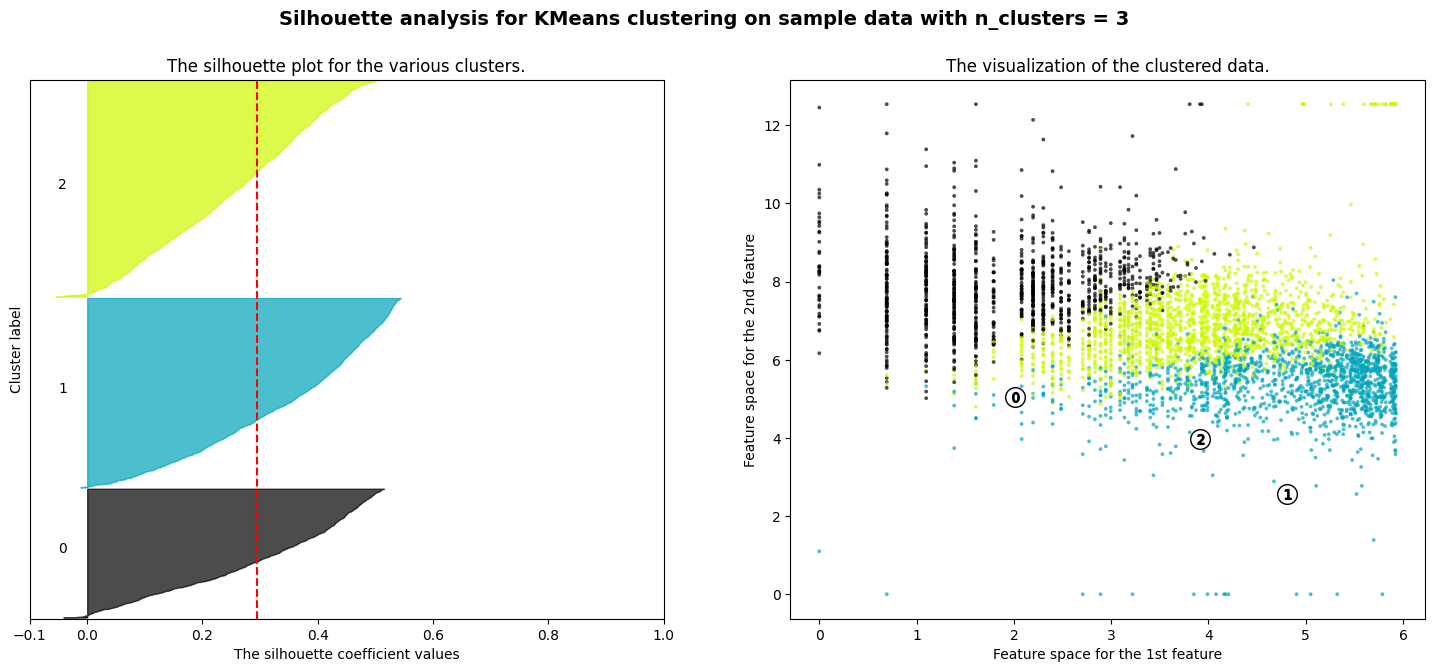

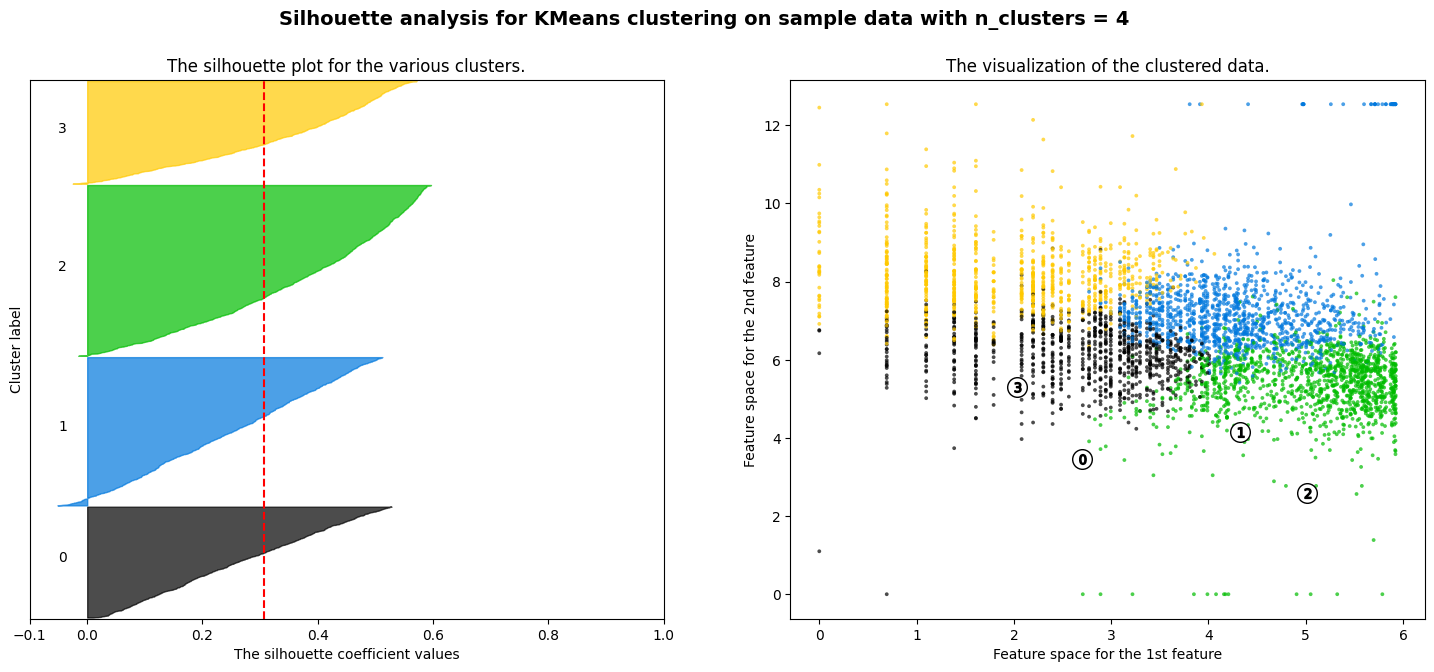

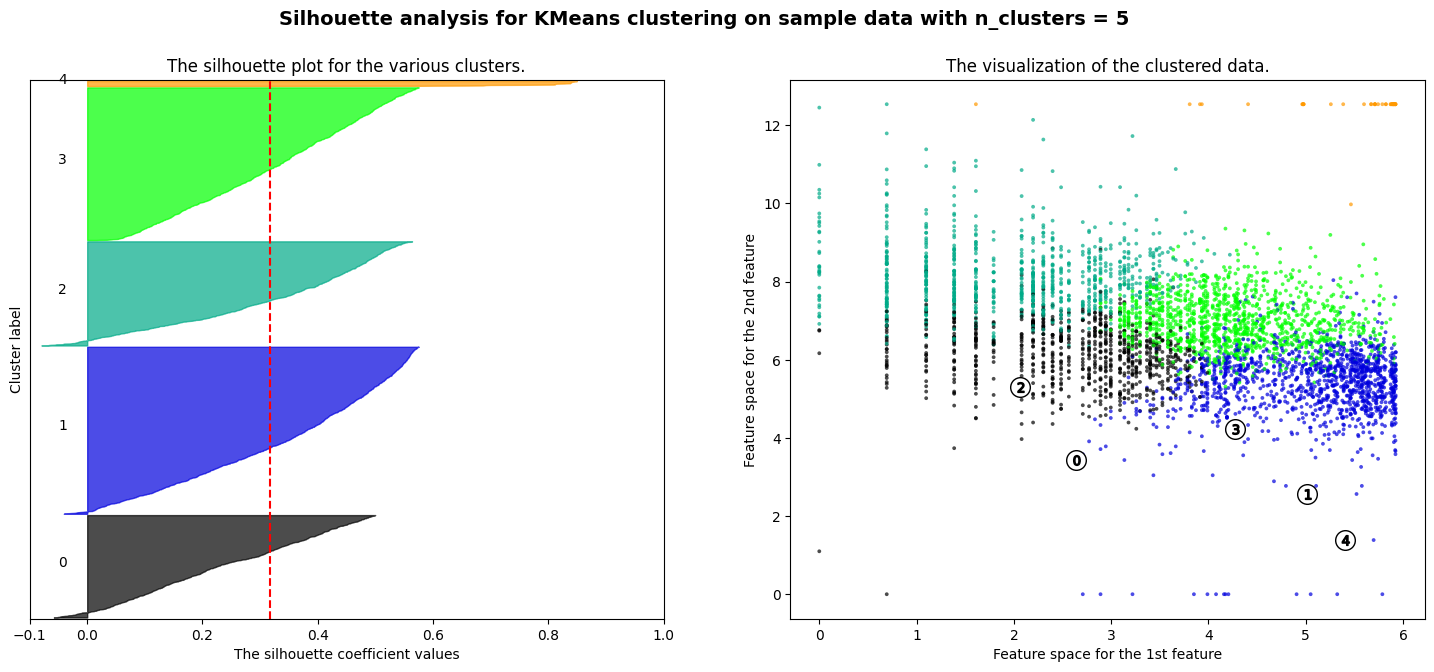

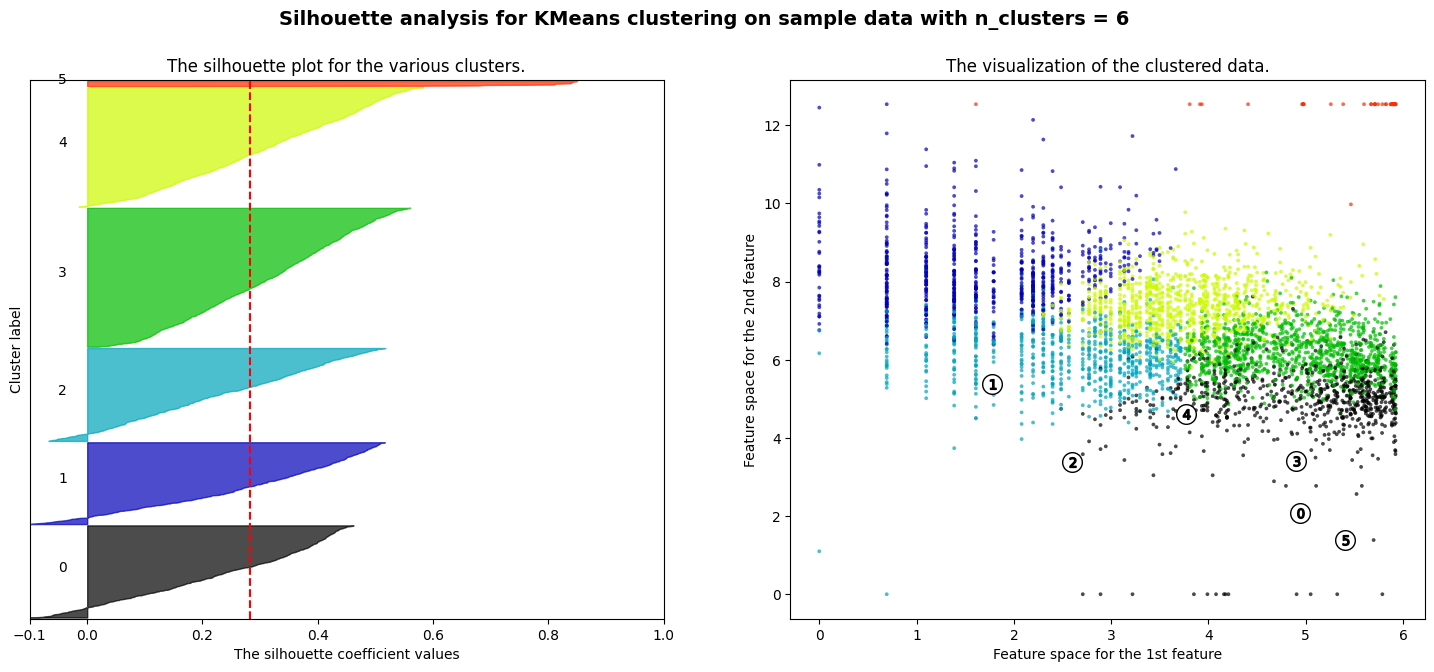

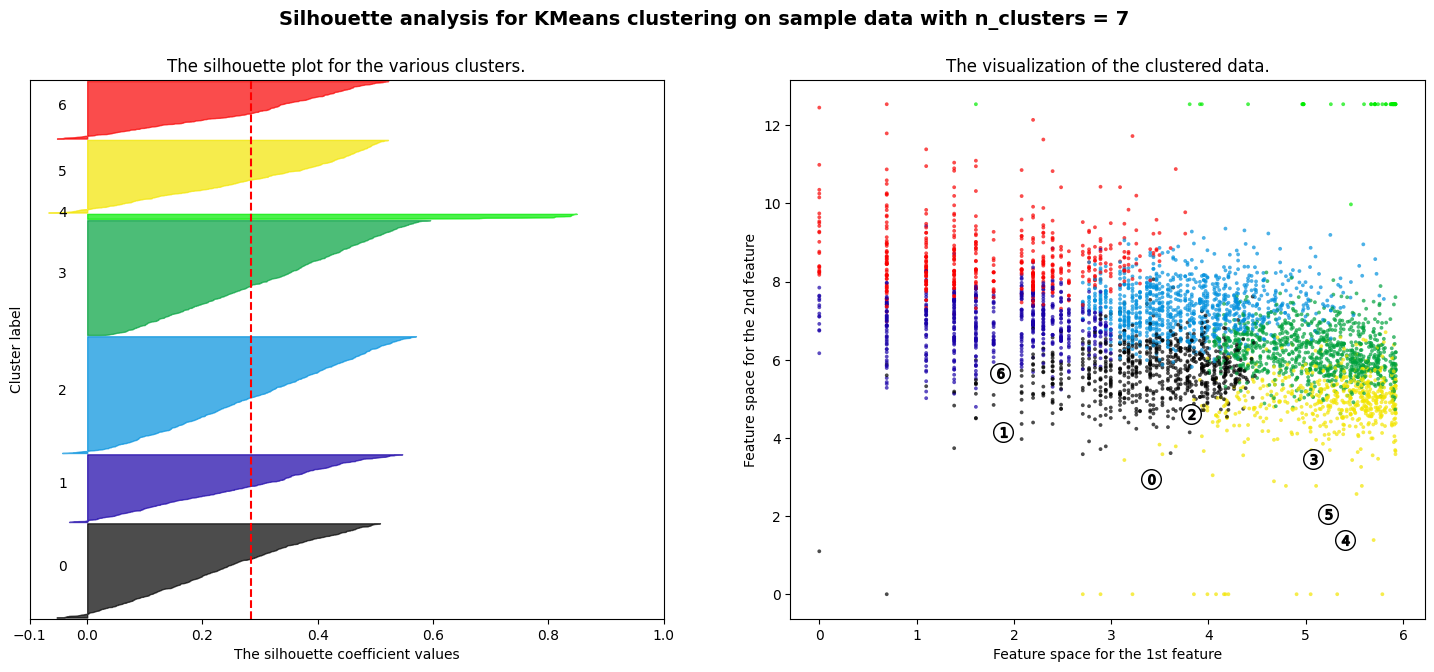

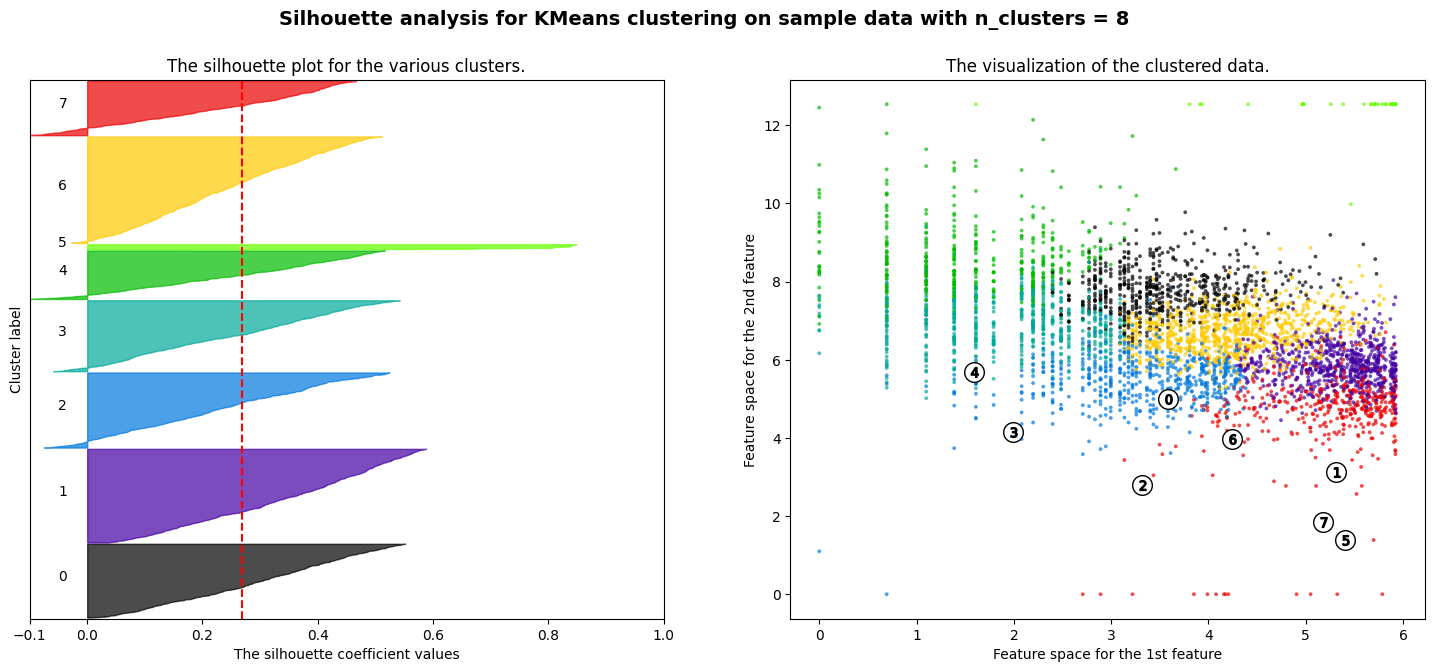

In [289]:
#On log transformed values
for n_clust in range_n_clusters:
     # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(rfm_ft) + (n_clust + 1) * 10])

    clusterer = KMeans(n_clusters=  n_clust)
    cluster_labels = clusterer.fit_predict(rfm_ft)

    sil_avg = silhouette_score(rfm_ft, cluster_labels)
    print("For n_clusters =", n_clust, "The average silhouette_score is :", sil_avg)

    sample_silval = silhouette_samples(rfm_ft, cluster_labels)
    sample_silval = sample_silval if isinstance(sample_silval, np.ndarray) else sample_silval.values

    y_lower = 10
    for i in range(n_clust):
      ith_clust_silval = sample_silval[cluster_labels == i]
      ith_clust_silval.sort()
      size_clusteri = ith_clust_silval.shape[0]
      y_upper = y_lower + size_clusteri
      color = cm.nipy_spectral(float(i) / n_clust)
      ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_clust_silval, facecolor=color, edgecolor=color, alpha=0.7)
    # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_clusteri, str(i))
      # Compute the new y_lower for the next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

     # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clust)
    ax2.scatter(rfm_ft['Recency'], rfm_ft['Monetary'], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clust),
                 fontsize=14, fontweight='bold')


plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

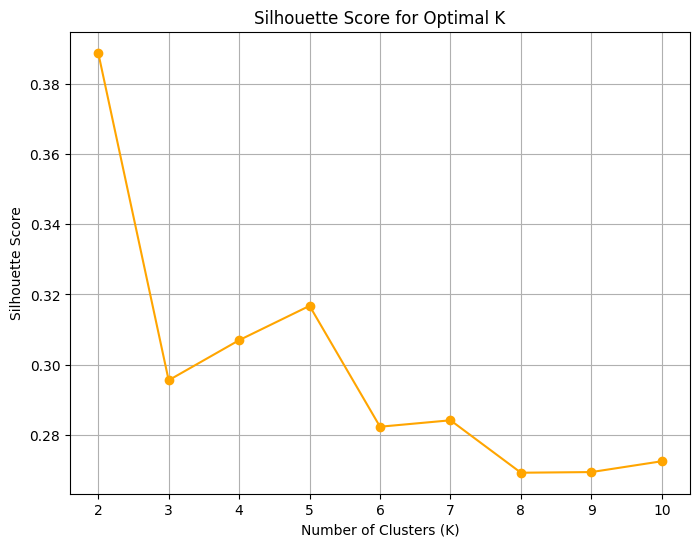

In [290]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(rfm_ft)
    silhouette_avg = silhouette_score(rfm_ft, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score graph
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='orange')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [291]:
from sklearn.manifold import TSNE

In [292]:
rfm_ft.head()

Recency  Frequency  Monetary
0  5.786897   1.098612  0.000000
1  1.098612   5.209486  8.368925
2  4.330733   3.465736  7.494430
3  2.944439   4.304065  7.471932
4  5.739793   2.890372  5.814131

In [293]:
scaler = StandardScaler()
scaler.fit(rfm_val)
rfmlog_scaled = scaler.transform(rfm_val)

In [294]:
rfm_val.head()

CustomerID   Recency  Frequency  Monetary
0     12346.0  5.786897   1.098612  0.000000
1     12347.0  1.098612   5.209486  8.368925
2     12348.0  4.330733   3.465736  7.494430
3     12349.0  2.944439   4.304065  7.471932
4     12350.0  5.739793   2.890372  5.814131

In [295]:
rfmlog_scaled = pd.DataFrame(rfmlog_scaled, index=rfm_val.index, columns = rfm_val.columns)
rfmlog_scaled.head()

CustomerID   Recency  Frequency  Monetary
0   -1.715067  1.428946  -2.096293 -4.661604
1   -1.714486 -1.889472   1.173006  1.248316
2   -1.713906  0.398257  -0.213765  0.630770
3   -1.713325 -0.582976   0.452942  0.614883
4   -1.712744  1.395605  -0.671341 -0.555814

In [296]:
rfm_df.head()

CustomerID  Recency  Frequency  Monetary
0     12346.0      325          2         0
1     12347.0        2        182      4310
2     12348.0       75         31      1797
3     12349.0       18         73      1757
4     12350.0      310         17       334

In [297]:
def kmeans(rfm_ft, clusters_number, rfm_df):

    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(rfm_ft)
# Extract cluster labels
    cluster_labels = kmeans.labels_+1

    # Create a cluster label column in original dataset
    df_new = rfm_df.assign(Cluster = cluster_labels)

    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)

    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    return df_new

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


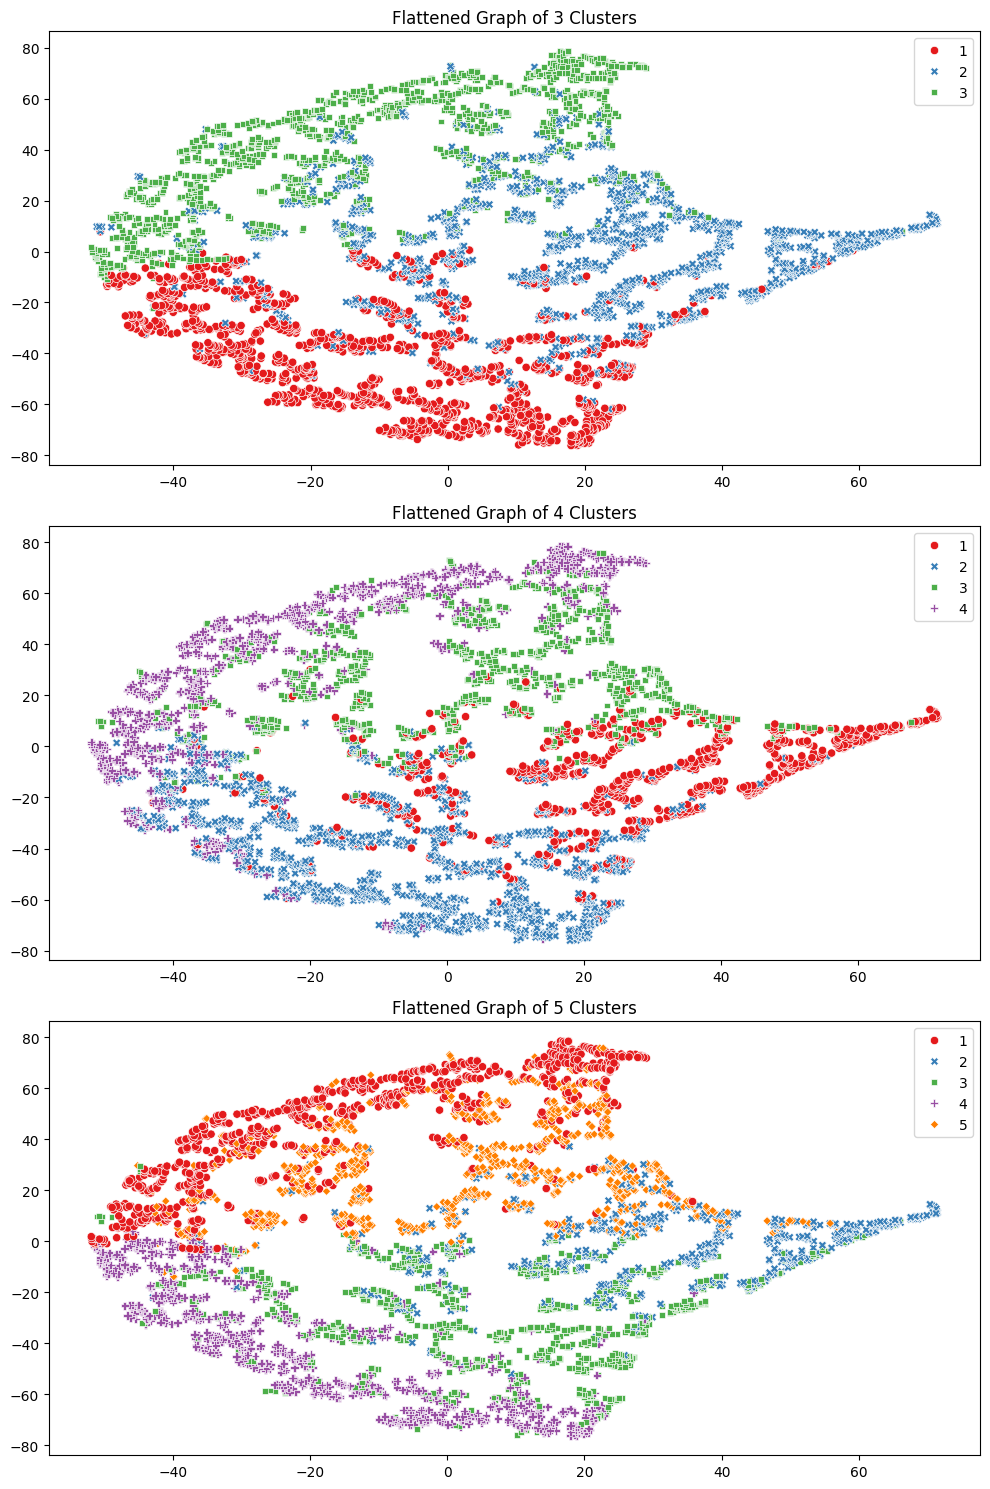

In [298]:
plt.figure(figsize=(10, 15))
plt.subplot(3, 1, 1)
rfm_k3 = kmeans(rfmlog_scaled, 3, rfm_df)
plt.subplot(3, 1, 2)
rfm_k4 = kmeans(rfmlog_scaled, 4, rfm_df)
plt.subplot(3, 1, 3)
rfm_k5 = kmeans(rfmlog_scaled, 5, rfm_df)
plt.tight_layout()

**Snake Plot**

In [ ]:
def snake_plot(rfmlog_ft, clusters_number, rfm_df):
rfmlog_ft = pd.DataFrame(rfmlog_ft, index=rfm_df.index, columns=rfm_df.columns)
    rfmlog_ft['Cluster'] = df_rfm_kmeans['Cluster']
# Melt data into long format
    df_melt = pd.melt(rfmlog_ft.reset_index(),
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'],
                        var_name='Metric',
                        value_name='Value')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')

    return

**5. Segment Profiling**

In [299]:
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)

    # Sort by cluster
    df_new = df_new.sort_values(by='Cluster', ascending=True)

    return df_new

rfm_values(rfm_k4)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
1          15.0     261.0   6241.0   868
2         117.0      35.0    666.0  1298
3          49.0      97.0   1477.0  1151
4         169.0      16.0    280.0  1055

In [300]:
rfm_k4.head()

CustomerID  Recency  Frequency  Monetary  Cluster
0     12346.0      325          2         0        4
1     12347.0        2        182      4310        1
2     12348.0       75         31      1797        2
3     12349.0       18         73      1757        1
4     12350.0      310         17       334        2

In [301]:
rfm_copy.head()

CustomerID   Recency  Frequency  Monetary  RecencyScore  FrequencyScore  \
0     12346.0  5.786897   1.098612  0.000000             4               4   
1     12347.0  1.098612   5.209486  8.368925             1               1   
2     12348.0  4.330733   3.465736  7.494430             3               3   
3     12349.0  2.944439   4.304065  7.471932             2               2   
4     12350.0  5.739793   2.890372  5.814131             4               4   

   MonetaryScore  RFMScore  RFMsum  
0              4       444      12  
1              1       111       3  
2              1       331       7  
3              1       221       5  
4              3       443      11

In [302]:
rfm_df.head()

CustomerID  Recency  Frequency  Monetary
0     12346.0      325          2         0
1     12347.0        2        182      4310
2     12348.0       75         31      1797
3     12349.0       18         73      1757
4     12350.0      310         17       334

Cluster 1 - Loyal Customers <br>
Customers in this cluster can be interpreted as very Loyal Customers as they frequently buy and their rceency is also one if the least. They tend to spend a lot.

Cluster 2 - Passerby Customer <br>
Customers in this cluster can be interpreted as passerby customers as their last purchase is long ago (R=4), purchased very few (F=4) and spent little (M=4). The company would have to come up with new strategies to make them permanent members.

Cluster 3 - Best Customers <br>
Customers in this cluster can be interpreted as “Best Customers” segment as they purchase recently (R=1), frequent buyers (F=1), and spent the most (M=1).

Cluster 4 - Almost Lost Customers <br>
Customers in this cluster can be interpreted as “Almost Lost” customers as they Haven’t purchased for some time(R=3) but used to purchase frequently and spent a lot.



In [303]:
rfm_copy = rfm_copy.merge(rfm_k4[['CustomerID', 'Cluster']])
rfm_copy.head()

CustomerID   Recency  Frequency  Monetary  RecencyScore  FrequencyScore  \
0     12346.0  5.786897   1.098612  0.000000             4               4   
1     12347.0  1.098612   5.209486  8.368925             1               1   
2     12348.0  4.330733   3.465736  7.494430             3               3   
3     12349.0  2.944439   4.304065  7.471932             2               2   
4     12350.0  5.739793   2.890372  5.814131             4               4   

   MonetaryScore  RFMScore  RFMsum  Cluster  
0              4       444      12        4  
1              1       111       3        1  
2              1       331       7        2  
3              1       221       5        1  
4              3       443      11        2

In [304]:
# Assuming the 'CustomerID' column is the common column between rfm_df and rfm_copy
rfm_df = rfm_df.merge(rfm_k4[['CustomerID', 'Cluster']])
rfm_df.head()

CustomerID  Recency  Frequency  Monetary  Cluster
0     12346.0      325          2         0        4
1     12347.0        2        182      4310        1
2     12348.0       75         31      1797        2
3     12349.0       18         73      1757        1
4     12350.0      310         17       334        2

In [307]:
# Analyze and profile each customer segment


for cluster_label in range(1, 5):
    cluster_data = rfm_df[rfm_df['Cluster'] == cluster_label]

    print(f"\n\n------ Profile for Cluster {cluster_label} ------")

    # General statistics
    print("Cluster Size:", len(cluster_data))

    # RFM scores
    print("Recency:")
    print("Mean:", cluster_data['Recency'].mean())
    print("Min:", cluster_data['Recency'].min())
    print("Max:", cluster_data['Recency'].max())

    print("\nFrequency:")
    print("Mean:", cluster_data['Frequency'].mean())
    print("Min:", cluster_data['Frequency'].min())
    print("Max:", cluster_data['Frequency'].max())

    print("\nMonetary Value:")
    print("Mean:", cluster_data['Monetary'].mean())
    print("Min:", cluster_data['Monetary'].min())
    print("Max:", cluster_data['Monetary'].max())



------ Profile for Cluster 1 ------
Cluster Size: 868
Recency:
Mean: 15.19815668202765
Min: 0
Max: 301

Frequency:
Mean: 260.5990783410138
Min: 3
Max: 7812

Monetary Value:
Mean: 6240.5288018433175
Min: -71
Max: 279489


------ Profile for Cluster 2 ------
Cluster Size: 1298
Recency:
Mean: 117.11325115562404
Min: 1
Max: 373

Frequency:
Mean: 35.422187981510014
Min: 1
Max: 233

Monetary Value:
Mean: 665.997688751926
Min: -1192
Max: 9861


------ Profile for Cluster 3 ------
Cluster Size: 1151
Recency:
Mean: 49.27193744569939
Min: 0
Max: 372

Frequency:
Mean: 97.4118158123371
Min: 1
Max: 1268

Monetary Value:
Mean: 1477.1694178974803
Min: -4287
Max: 26763


------ Profile for Cluster 4 ------
Cluster Size: 1055
Recency:
Mean: 169.17156398104265
Min: 0
Max: 373

Frequency:
Mean: 16.402843601895736
Min: 1
Max: 97

Monetary Value:
Mean: 279.5886255924171
Min: 0
Max: 2560


In [315]:
rfm_df[["Cluster", "Recency", "Frequency", "Monetary"]].groupby("Cluster").agg(["mean", "sum", "count"])

Recency                 Frequency                   Monetary  \
               mean     sum count        mean     sum count         mean   
Cluster                                                                    
1         15.198157   13192   868  260.599078  226200   868  6240.528802   
2        117.113251  152013  1298   35.422188   45978  1298   665.997689   
3         49.271937   56712  1151   97.411816  112121  1151  1477.169418   
4        169.171564  178476  1055   16.402844   17305  1055   279.588626   

                        
             sum count  
Cluster                 
1        5416779   868  
2         864465  1298  
3        1700222  1151  
4         294966  1055


--- Customer Segment 4 ---
Number of Customers: 1055

RFM Statistics:
           Recency    Frequency     Monetary
count  1055.000000  1055.000000  1055.000000
mean    169.171564    16.402844   279.588626
std     110.643383    13.508020   246.970724
min       0.000000     1.000000     0.000000
25%      64.000000     7.000000   134.500000
50%     165.000000    13.000000   217.000000
75%     261.000000    23.000000   342.500000
max     373.000000    97.000000  2560.000000


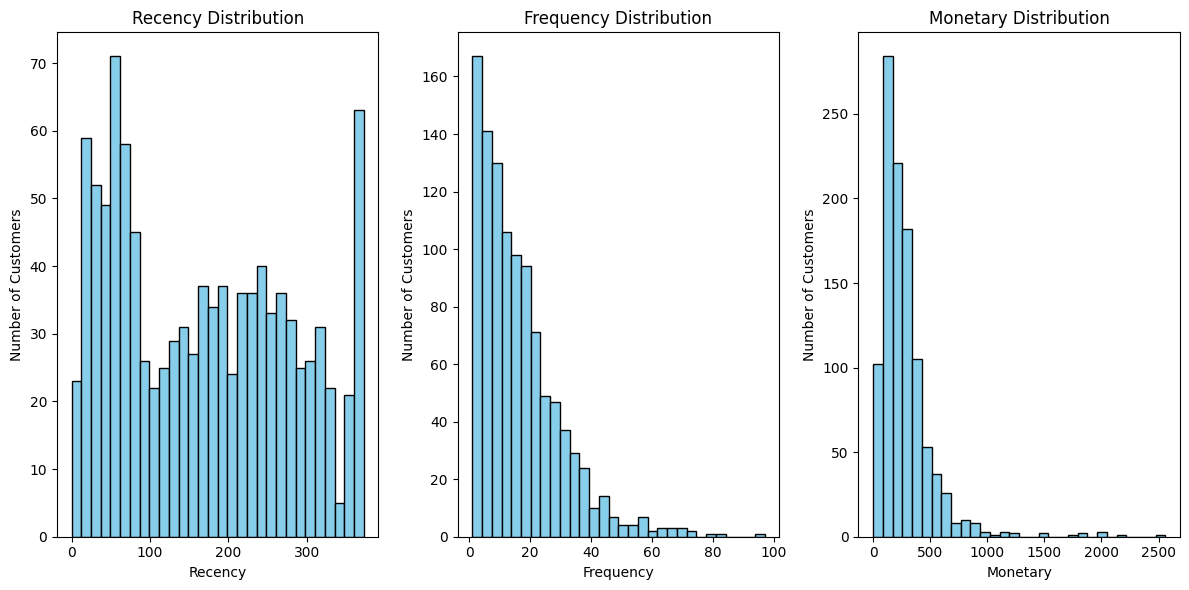


--- Customer Segment 1 ---
Number of Customers: 868

RFM Statistics:
          Recency    Frequency       Monetary
count  868.000000   868.000000     868.000000
mean    15.198157   260.599078    6240.528802
std     22.536857   461.060788   17634.508073
min      0.000000     3.000000     -71.000000
25%      3.000000   102.750000    1639.000000
50%      8.000000   164.000000    2774.500000
75%     19.000000   286.000000    4974.250000
max    301.000000  7812.000000  279489.000000


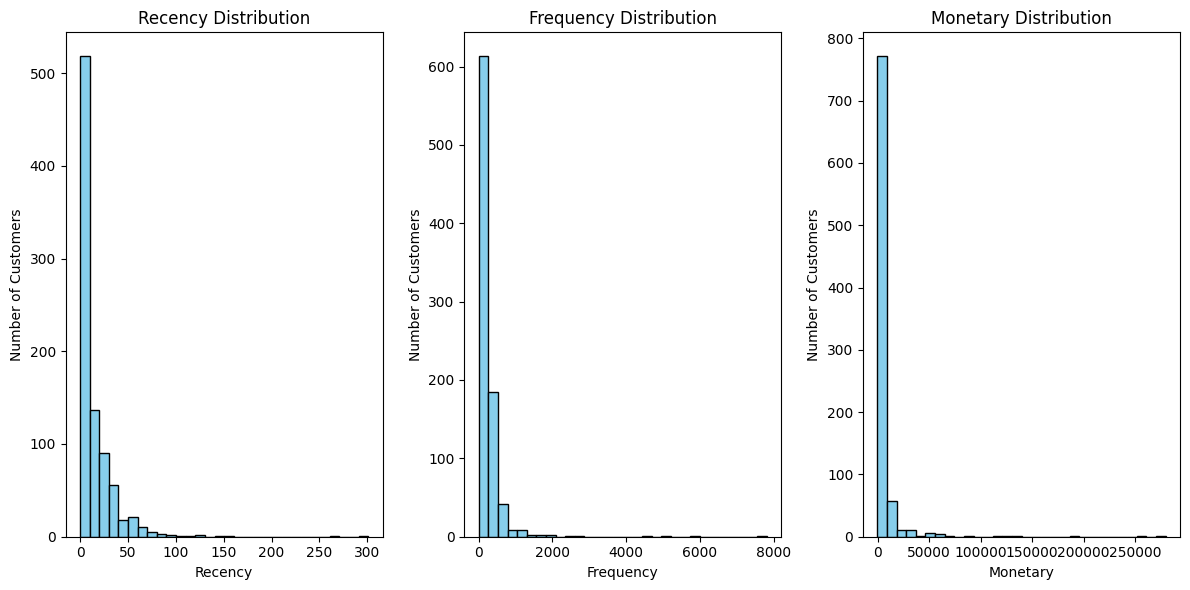


--- Customer Segment 2 ---
Number of Customers: 1298

RFM Statistics:
           Recency    Frequency     Monetary
count  1298.000000  1298.000000  1298.000000
mean    117.113251    35.422188   665.997689
std      98.577603    28.544284   730.512607
min       1.000000     1.000000 -1192.000000
25%      38.000000    15.000000   272.000000
50%      79.000000    28.000000   476.000000
75%     182.000000    48.000000   841.000000
max     373.000000   233.000000  9861.000000


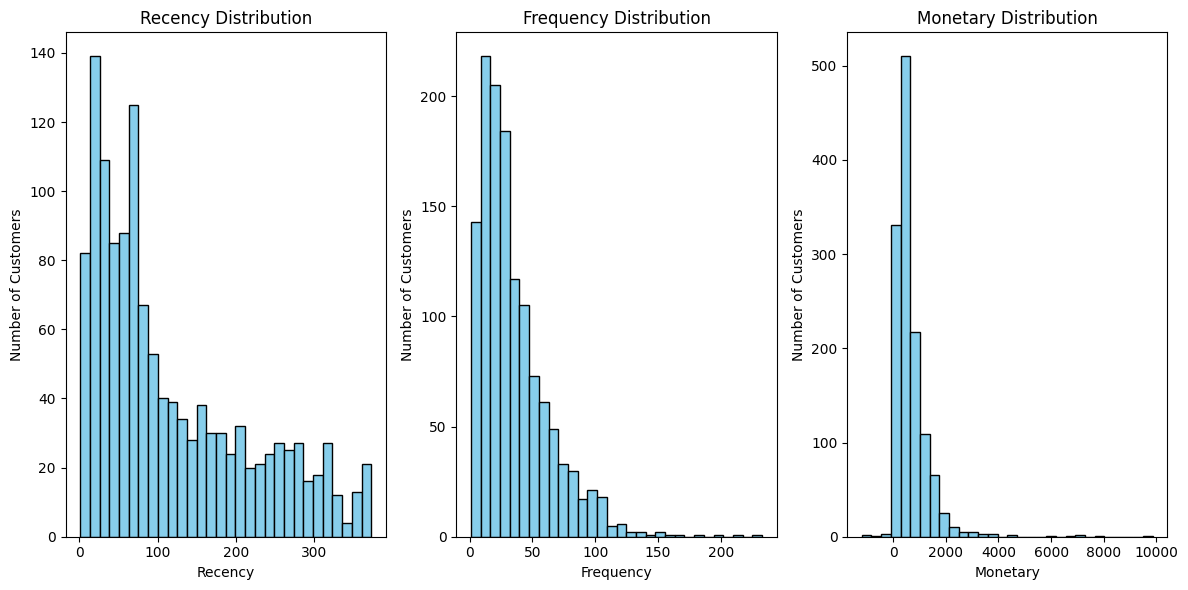


--- Customer Segment 3 ---
Number of Customers: 1151

RFM Statistics:
           Recency    Frequency      Monetary
count  1151.000000  1151.000000   1151.000000
mean     49.271937    97.411816   1477.169418
std      59.843563    89.553020   1761.874958
min       0.000000     1.000000  -4287.000000
25%      14.000000    43.000000    612.000000
50%      29.000000    74.000000   1026.000000
75%      60.000000   122.500000   1791.000000
max     372.000000  1268.000000  26763.000000


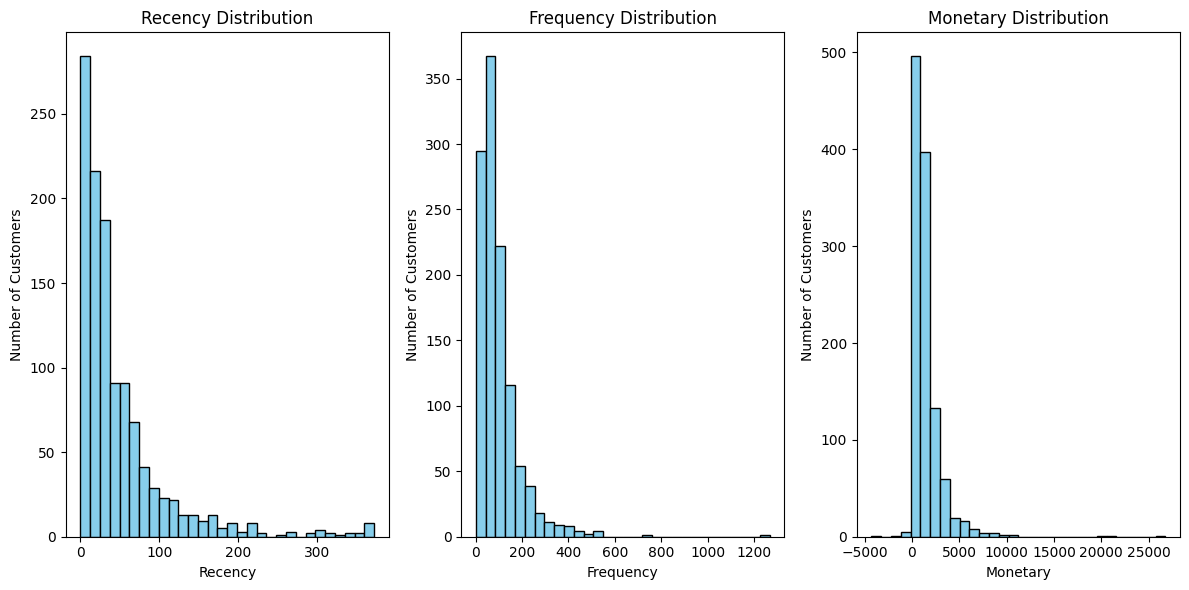

In [316]:
# Profile each customer segment
for cluster in rfm_df['Cluster'].unique():
    segment_data = rfm_df[rfm_df['Cluster'] == cluster]

    print(f"\n--- Customer Segment {cluster} ---")
    print("Number of Customers:", len(segment_data))

    # Analyze RFM scores
    rfm_stats = segment_data[['Recency', 'Frequency', 'Monetary']].describe()
    print("\nRFM Statistics:")
    print(rfm_stats)

    # Other relevant attributes can be analyzed similarly

    # You can also visualize the distribution of RFM scores within each segment
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.hist(segment_data['Recency'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Recency Distribution')
    plt.xlabel('Recency')
    plt.ylabel('Number of Customers')

    plt.subplot(1, 3, 2)
    plt.hist(segment_data['Frequency'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Frequency Distribution')
    plt.xlabel('Frequency')
    plt.ylabel('Number of Customers')

    plt.subplot(1, 3, 3)
    plt.hist(segment_data['Monetary'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Monetary Distribution')
    plt.xlabel('Monetary')
    plt.ylabel('Number of Customers')

    plt.tight_layout()
    plt.show()


**6. MARKETING RECOMMENDATIONS**

High-Value and Recently Active Customers:

Personalized Offers: Provide exclusive promotions or discounts for their next purchase to capitalize on their recent activity.
Loyalty Programs: Introduce a loyalty program to reward and retain these high-value customers.
Product Recommendations: Utilize personalized product recommendations based on their past purchases to encourage additional buying.

Regular but Less Recent Customers:
Reactivation Campaigns: Launch targeted reactivation campaigns to remind them of your products and services.
Special Promotions: Offer time-limited promotions to incentivize quick re-engagement.
Survey Feedback: Collect feedback through surveys to understand any potential barriers to recent purchases and address them.

High-Frequency but Lower Monetary Value:
 Bundle Offers: Introduce bundled products or package deals to increase the average transaction value.
Cross-Sell Strategies: Implement cross-selling strategies to encourage purchasing complementary products.
Exclusive Memberships: Consider creating a subscription or membership program to incentivize repeat business.

Infrequent and Low-Value Customers:
Win-Back Campaigns: Develop win-back campaigns to re-engage this segment with compelling offers.
Survey and Feedback: Conduct surveys to understand the reasons for infrequent purchases and tailor marketing efforts accordingly.
Incentivized Referrals: Encourage these customers to refer friends through referral programs.

**7. VISUALIZATION**

<ipython-input-317-a402e02cd668>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Recency', data=rfm_df, palette='Set3')


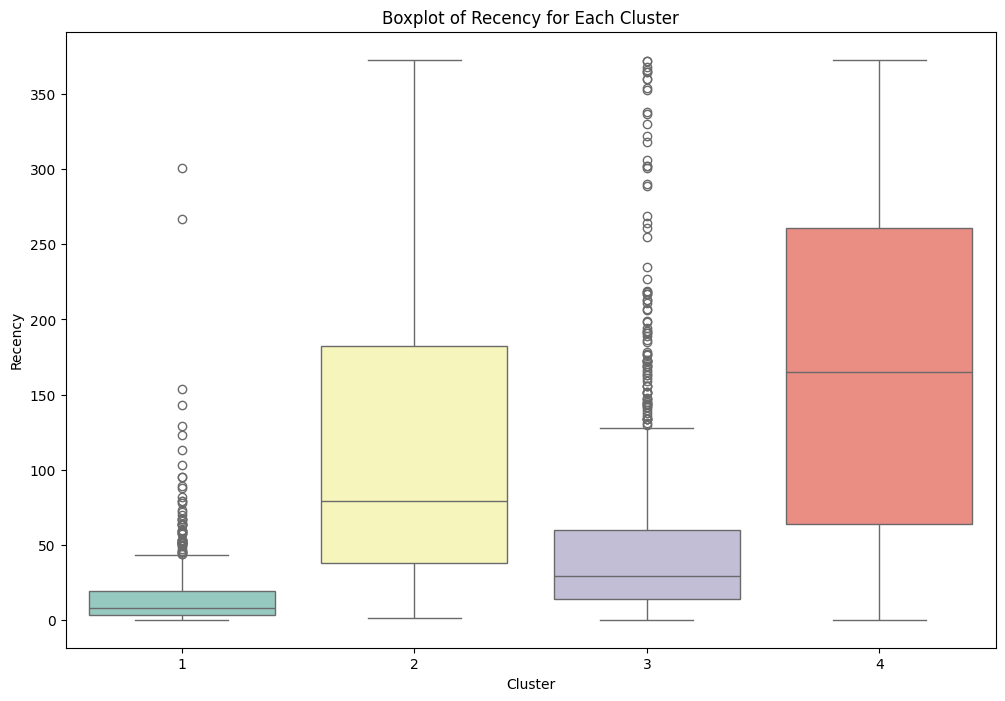

In [317]:
import seaborn as sns
import matplotlib.pyplot as plt
# Boxplot for RFM and Cluster Distribution
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='Recency', data=rfm_df, palette='Set3')
plt.title('Boxplot of Recency for Each Cluster')
plt.show()


<ipython-input-318-1f9704c8d031>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Recency', data=rfm_copy, palette='Set3')


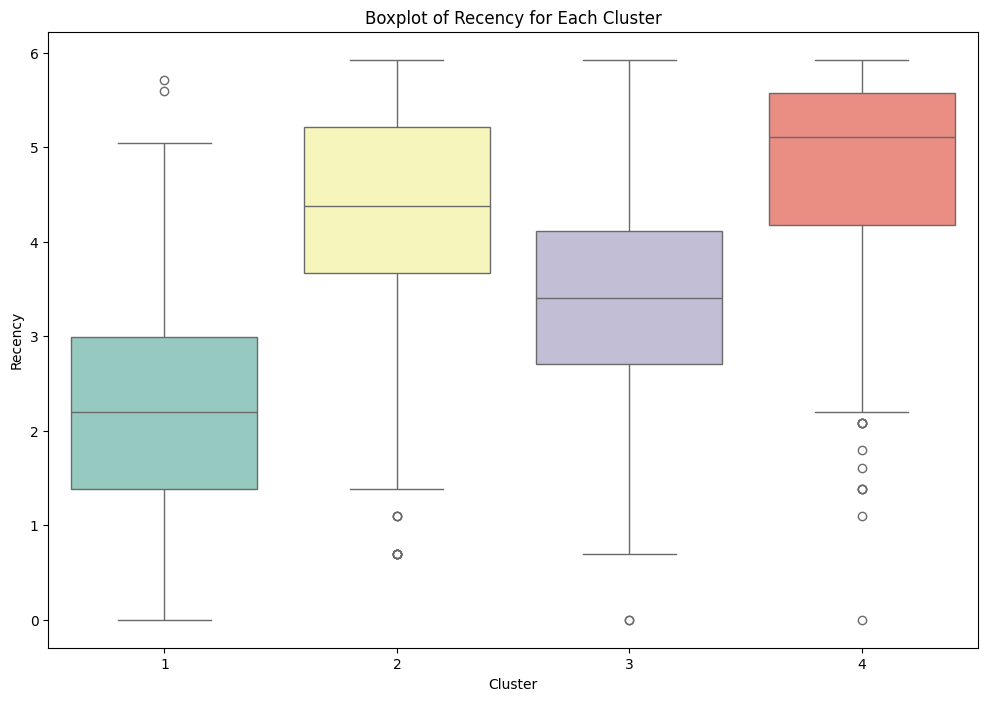

In [318]:
# Normalised Boxplot for RFM and Cluster Distribution
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='Recency', data=rfm_copy, palette='Set3')
plt.title('Boxplot of Recency for Each Cluster')
plt.show()


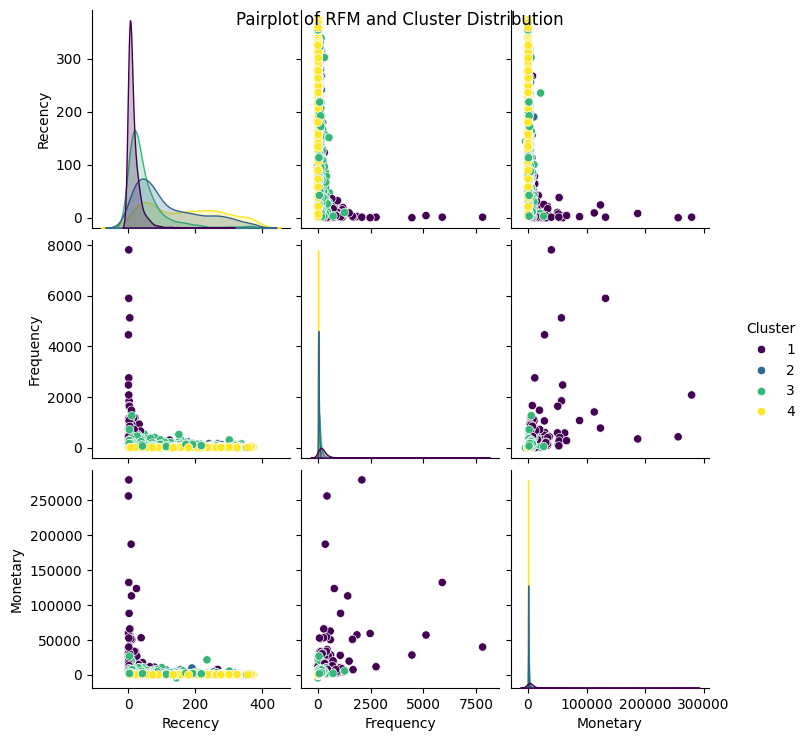

In [319]:
pairplot_data = rfm_df[['Recency', 'Frequency', 'Monetary', 'Cluster']]

# Plot pairplot
sns.pairplot(pairplot_data, hue='Cluster', palette='viridis')
plt.suptitle('Pairplot of RFM and Cluster Distribution')
plt.show()


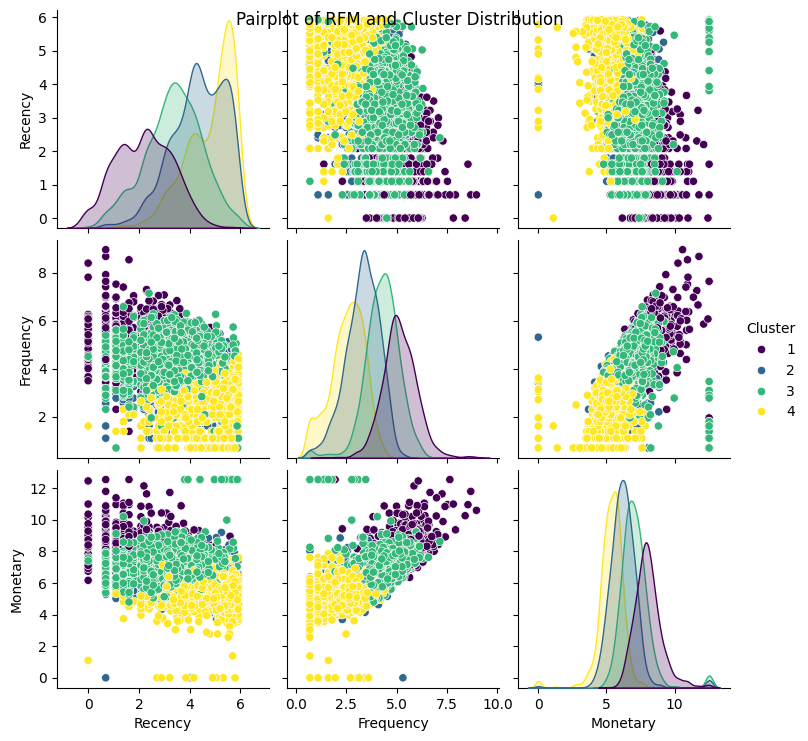

In [320]:
#Normalised
pairplot_data = rfm_copy[['Recency', 'Frequency', 'Monetary', 'Cluster']]

# Plot pairplot
sns.pairplot(pairplot_data, hue='Cluster', palette='viridis')
plt.suptitle('Pairplot of RFM and Cluster Distribution')
plt.show()


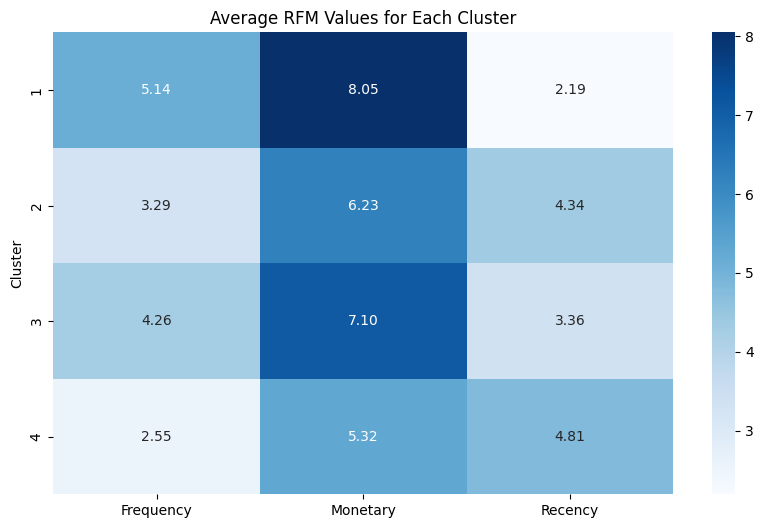

In [321]:
# Heatmap for Cluster Analysis
heatmap_data = rfm_copy.pivot_table(index='Cluster', values=['Recency', 'Frequency', 'Monetary'], aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.2f')
plt.title('Average RFM Values for Each Cluster')
plt.show()


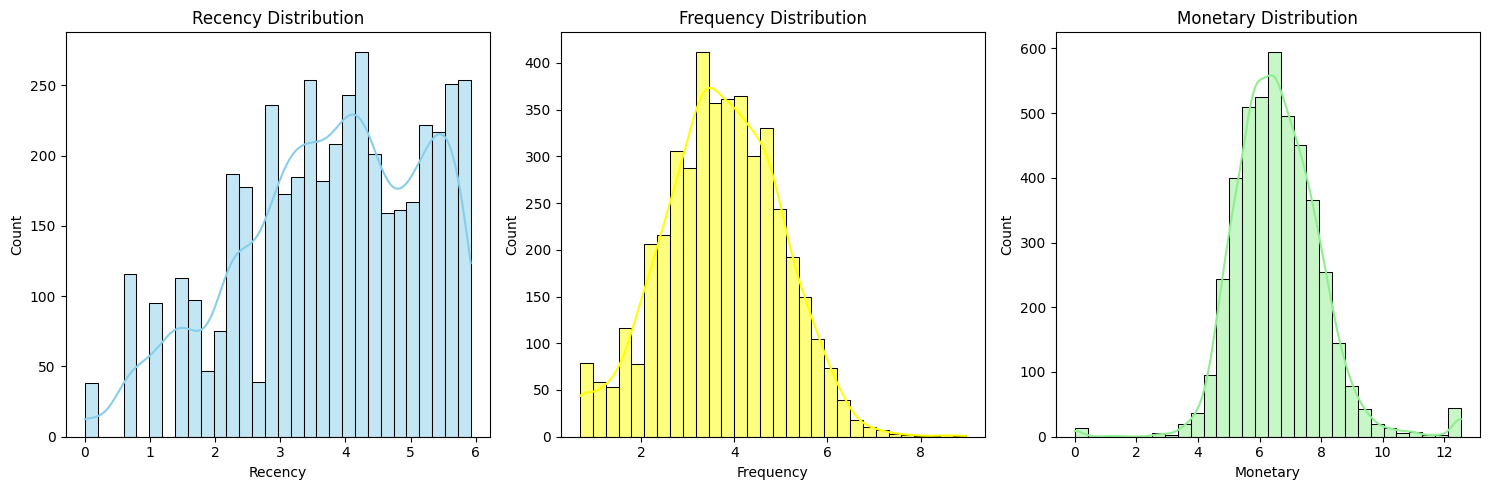

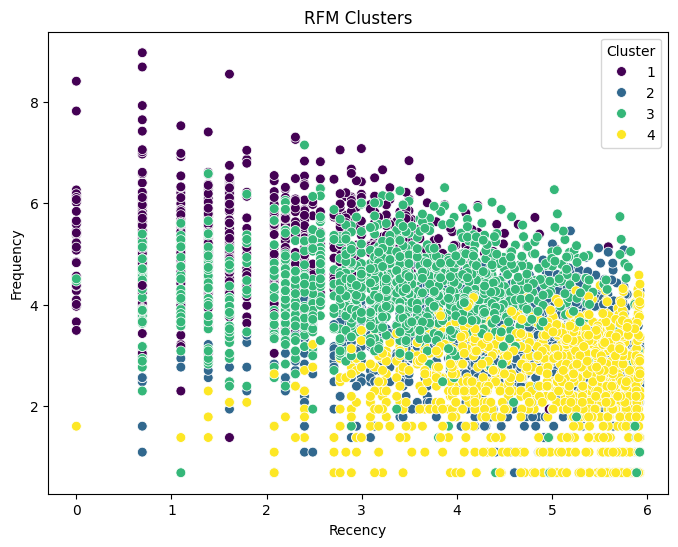

In [322]:
# Visualize the RFM distribution
plt.figure(figsize=(15, 5))

# Recency distribution
plt.subplot(1, 3, 1)
sns.histplot(rfm_copy['Recency'], bins=30, color='skyblue', kde=True)
plt.title('Recency Distribution')

# Frequency distribution
plt.subplot(1, 3, 2)
sns.histplot(rfm_copy['Frequency'], bins=30, color='yellow', kde=True)
plt.title('Frequency Distribution')

# Monetary distribution
plt.subplot(1, 3, 3)
sns.histplot(rfm_copy['Monetary'], bins=30, color='lightgreen', kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

# Visualize the clusters formed by K-Means
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm_copy, palette='viridis', s=50)
plt.title('RFM Clusters')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()


***Finding solutions to Questions***

**1.Data Overview**

1.1 Size of the dataset in terms of the number of rows and columns

In [323]:
customer.shape

(401604, 9)

1.2  Brief description of each column in the dataset

In [ ]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   Total Price  406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


1.3 Time period covered by the dataset

In [324]:
customer['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [325]:
customer['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [326]:
time_period= (customer['InvoiceDate'].max() - customer['InvoiceDate'].min()).days
print("The time period covered by the dataset is:", time_period)

The time period covered by the dataset is: 373


**2. CUSTOMER ANALYSIS**

2.1 Unique customers present in the dataset

In [328]:
cust_no =len(customer['CustomerID'].unique())
print("Total number of unique customers are:", cust_no)

Total number of unique customers are: 4372


2.2 Distribution of number of orders per customer.

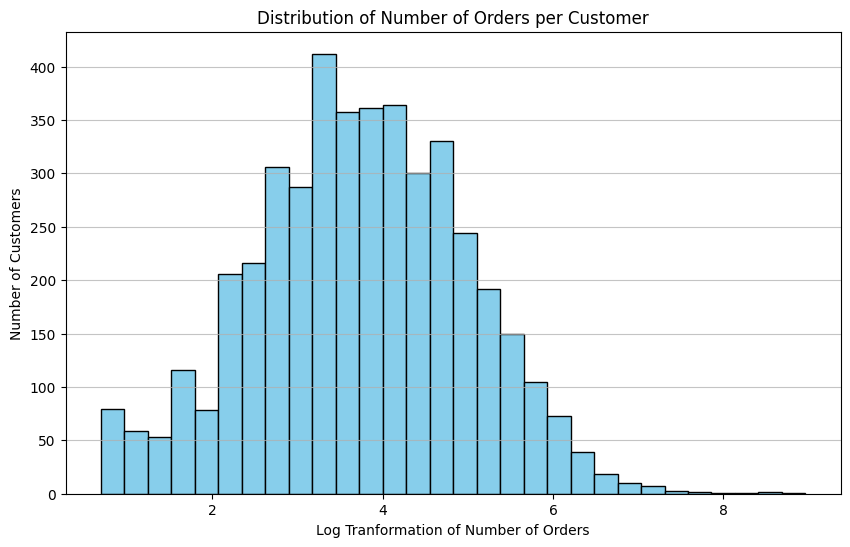

In [330]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot a histogram of the number of orders per customer
plt.figure(figsize=(10, 6))
plt.hist(rfm_copy['Frequency'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Orders per Customer')
plt.xlabel('Log Tranformation of Number of Orders')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.75)
#plt.xlim(0, 10)

plt.show()


In [ ]:
rfm_df['Frequency'].max()

248

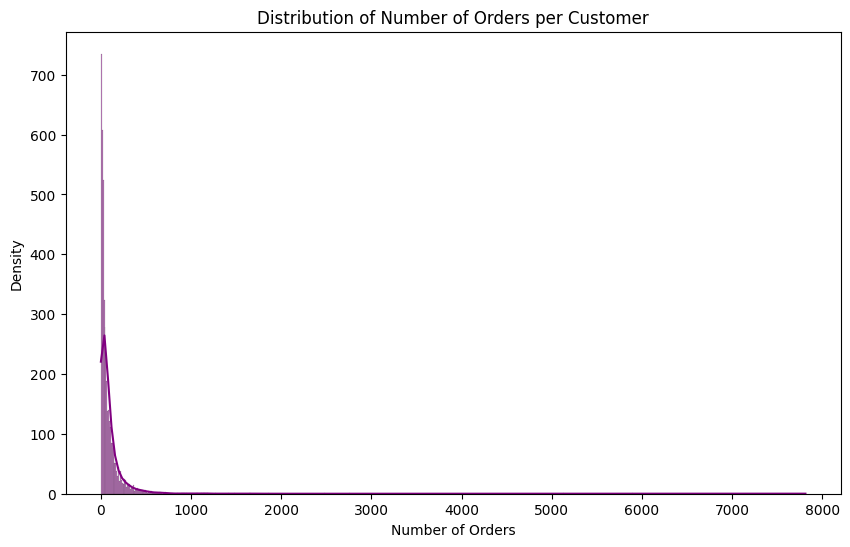

In [333]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a distribution plot (kernel density estimate) of the number of orders per customer
plt.figure(figsize=(10, 6))
sns.histplot(rfm_df['Frequency'], kde=True, color='purple', edgecolor='black')
plt.title('Distribution of Number of Orders per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Density')

# Show the plot
plt.show()


2.3 Top 5 Customers who made the most purchases

In [335]:
topCustomers = frequency_data.sort_values(by='Frequency', ascending=False).head(5)
topCustomers.head()

Frequency
CustomerID           
17841.0          7812
14911.0          5898
14096.0          5128
12748.0          4459
14606.0          2759

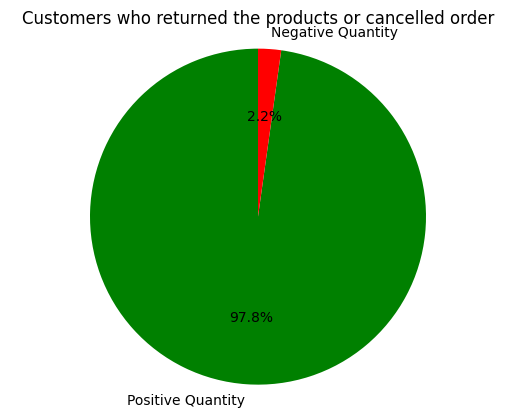

In [338]:
# Calculate the counts of customers with positive and negative quantities
positive_quantity_count = len(customer[customer['Quantity'] > 0])
negative_quantity_count = len(customer[customer['Quantity'] < 0])

# Create labels and values for the pie chart
labels = ['Positive Quantity', 'Negative Quantity']
values = [positive_quantity_count, negative_quantity_count]

# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Customers who returned the products or cancelled order')

plt.show()


**3 PRODUCT ANALYSIS**

3.1 What are the top 10 most frequently purchased products

In [339]:
top_products = customer['Description'].value_counts().head(10)
top_products.head()

WHITE HANGING HEART T-LIGHT HOLDER    2058
REGENCY CAKESTAND 3 TIER              1894
JUMBO BAG RED RETROSPOT               1659
PARTY BUNTING                         1409
ASSORTED COLOUR BIRD ORNAMENT         1405
Name: Description, dtype: int64

3.2 Average price of products in the dataset

In [340]:
avg_price= customer['UnitPrice'].sum()/len(customer)
avg_price

3.4740636398043865

3.3 Product Category generating highest revenue

In [341]:
maxrev_df = customer.groupby('Description')['Total Price'].sum().reset_index()
maxrev_df.head()

Description  Total Price
0   4 PURPLE FLOCK DINNER CANDLES       265.66
1   50'S CHRISTMAS GIFT BAG LARGE      2269.75
2               DOLLY GIRL BEAKER      2745.75
3     I LOVE LONDON MINI BACKPACK      1449.85
4     I LOVE LONDON MINI RUCKSACK         4.15

In [342]:
max_rev= maxrev_df.loc[maxrev_df['Total Price'].idxmax(), 'Description']
max_rev

'REGENCY CAKESTAND 3 TIER'

**4. TIME ANALYSIS**

4.1 Is there a specific day of the week or time of day when most orders are placed?

In [343]:
customer['InvoiceDate'] = pd.to_datetime(customer['InvoiceDate'], format='%Y/%m/%d')

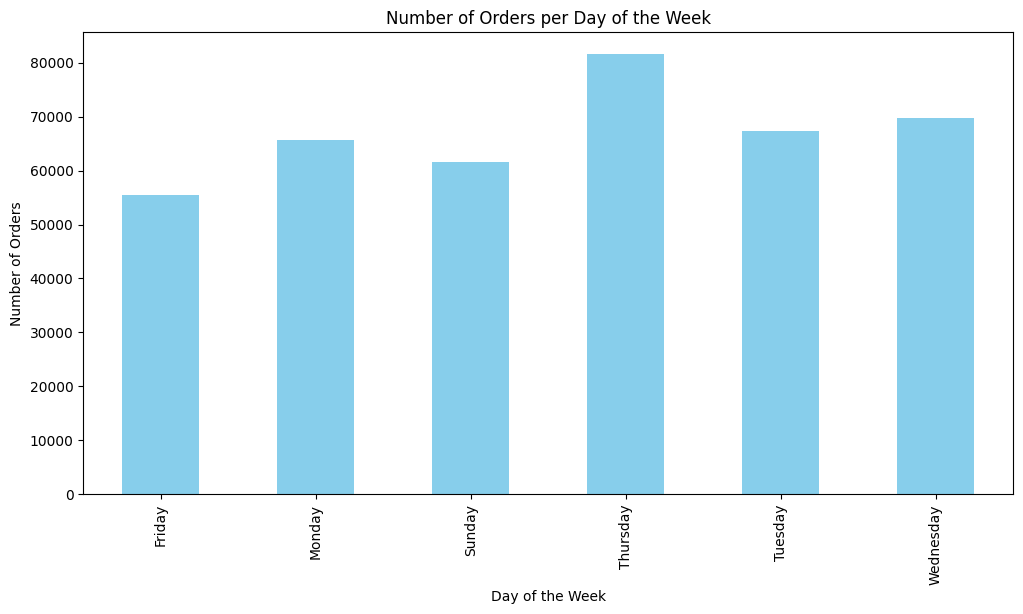

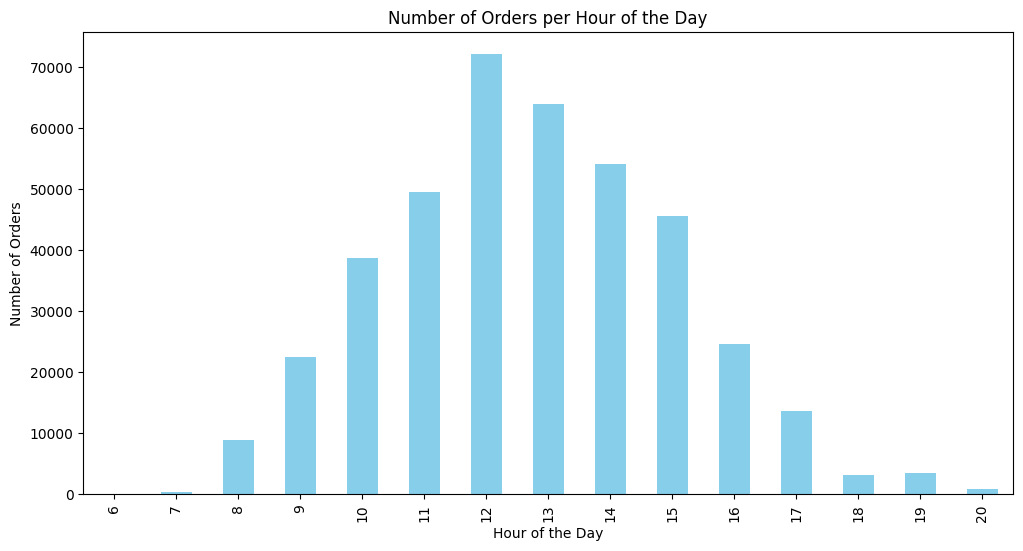

In [344]:
customer['DayOfWeek'] = customer['InvoiceDate'].dt.day_name()
customer['HourOfDay'] = customer['InvoiceDate'].dt.hour
plt.figure(figsize=(12, 6))
customer.groupby('DayOfWeek')['InvoiceNo'].count().plot(kind='bar', color='skyblue')
plt.title('Number of Orders per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.show()

# Plot the number of orders per hour of the day
plt.figure(figsize=(12, 6))
customer.groupby('HourOfDay')['InvoiceNo'].count().plot(kind='bar', color='skyblue')
plt.title('Number of Orders per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.show()

4.2  What is the average order processing time?

As there is no relevant column for the same, the average order processing can't be calculated. However, if a feature mentioning the order confirmation time is present, it can be calculated for every record

4.3 Are there any seasonal trends in the dataset?

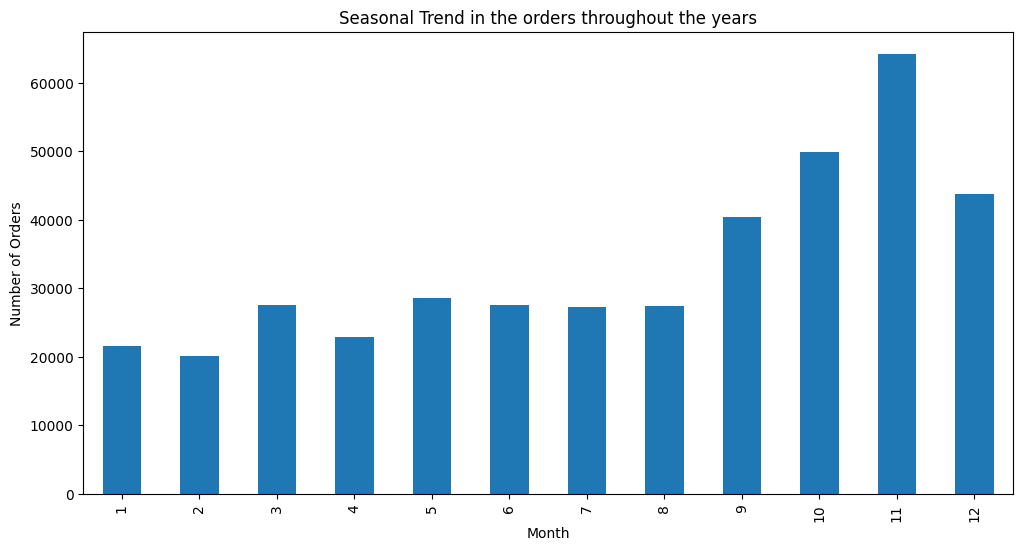

In [345]:
customer['Month'] = customer['InvoiceDate'].dt.month
plt.figure(figsize=(12, 6))
customer.groupby('Month')['InvoiceNo'].count().plot(kind='bar' )
plt.title('Seasonal Trend in the orders throughout the years')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.show()

The shopping trend increases around winters, or the holidays as people tend to buy gifts for their loved ones around the festivals

**5. GEOGRAPHICAL ANALYSIS**

5.1 Top 5 countries with the highest number of orders

In [346]:
top_countries=  customer['Country'].value_counts().head(5)
top_countries

United Kingdom    356728
Germany             9480
France              8475
EIRE                7475
Spain               2528
Name: Country, dtype: int64

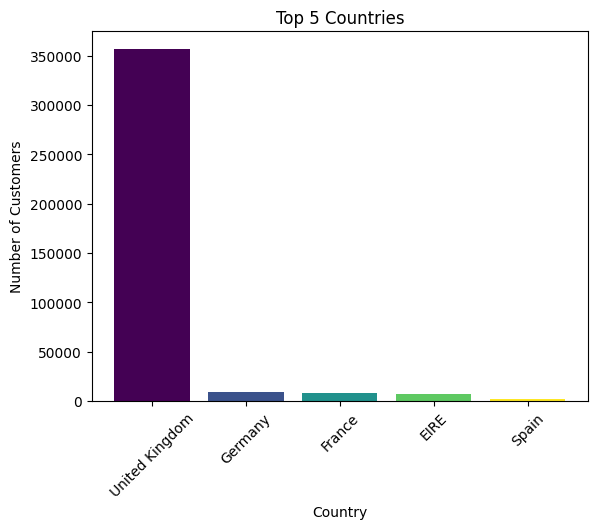

In [348]:
colors = plt.cm.viridis(np.linspace(0, 1, len(top_countries)))

# Create the bar chart
plt.bar(top_countries.index, top_countries, color=colors)

# Add labels and title
plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.title('Top 5 Countries')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

5.2 correlation between the country of the customer and the average order
value

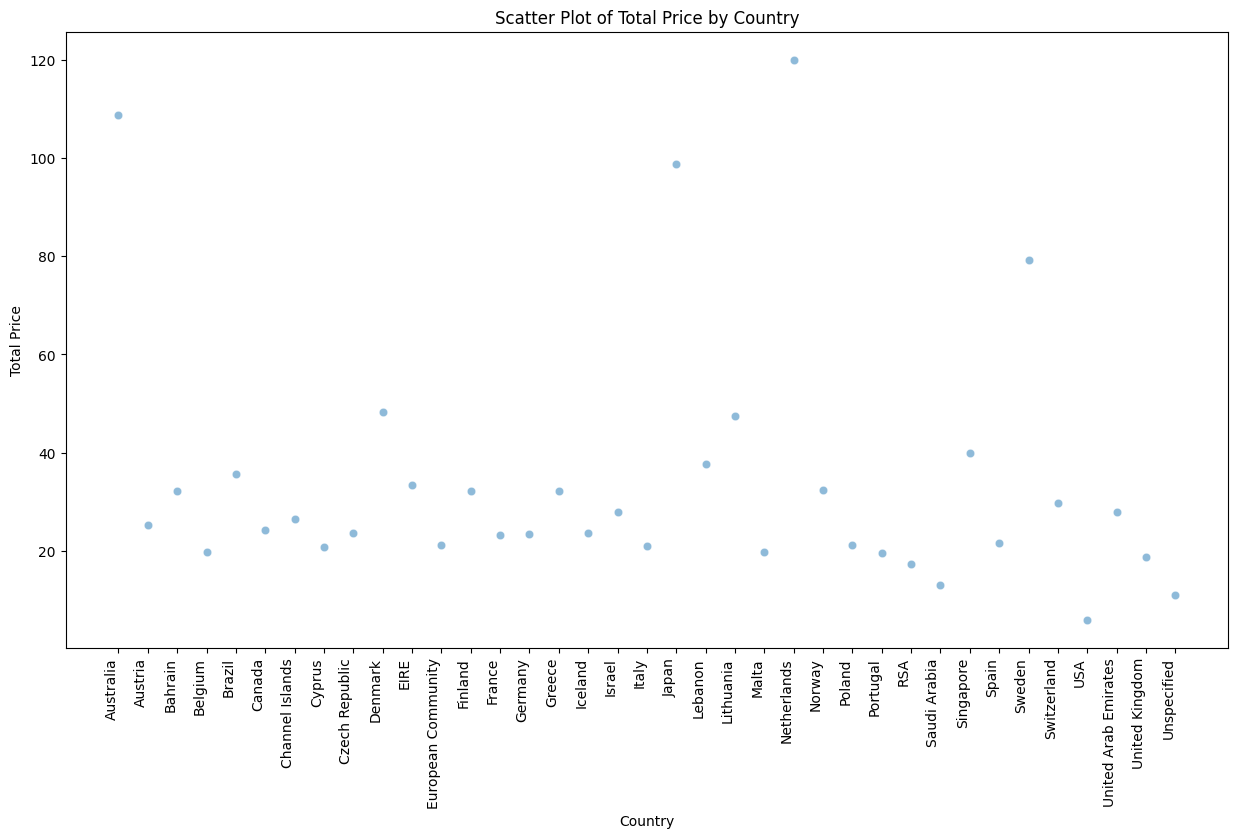

In [ ]:
avg_order_value_by_country = customer.groupby('Country')['Total Price'].mean().reset_index()

# Check the correlation
plt.figure(figsize=(15, 8))
sns.scatterplot(x='Country', y='Total Price', data=avg_order_value_by_country, alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

plt.xlabel('Country')
plt.ylabel('Total Price')
plt.title('Scatter Plot of Total Price by Country')

# Show the plot
plt.show()

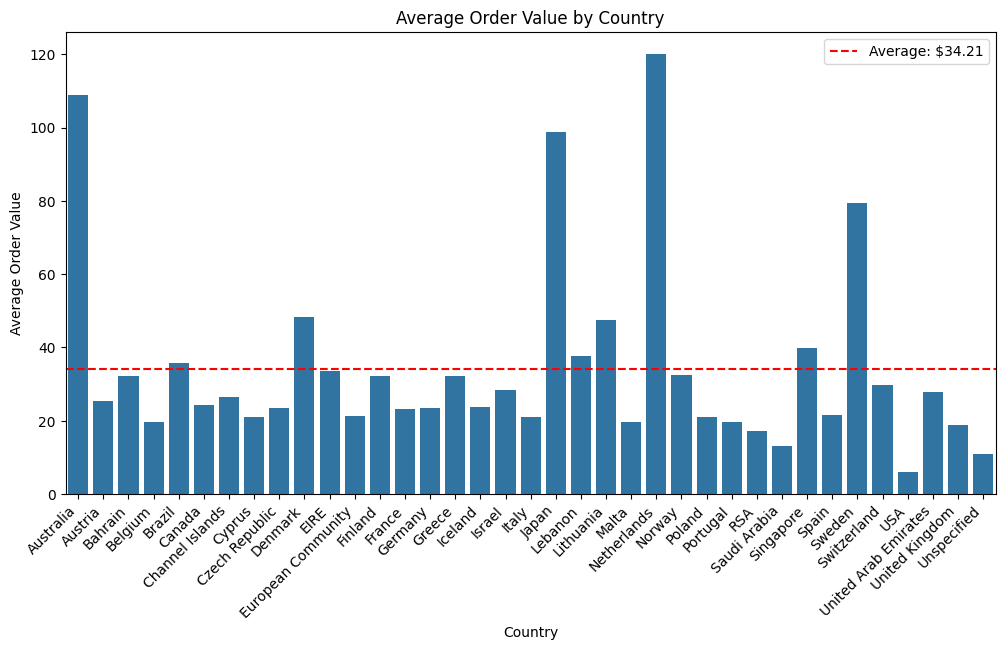

In [356]:
# Calculate average order value by country
avg_order_value_by_country = customer.groupby('Country')['Total Price'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='Total Price', data=avg_order_value_by_country)

# Add average markings to the plot
avg = avg_order_value_by_country['Total Price'].mean()
plt.axhline(y=avg, color='r', linestyle='--', label=f'Average: ${avg:.2f}')

# Add labels and title
plt.title('Average Order Value by Country')
plt.xlabel('Country')
plt.ylabel('Average Order Value')

# Rotate country labels for better readability
plt.xticks(rotation=45, ha='right')

# Show legend
plt.legend()

plt.show()


**6. Payment Analysis**

In [350]:
import random
payment= ['VISA', 'Master Card', 'Apple Pay', 'American Express', 'Discover', 'Google Pay', 'Paypal']
random.seed(42)
customer['Mode of Payment']= np.random.choice(payment, size= len(customer))
customer

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  \
0      2010-12-01 08:26:00       2.55     17850.0  United Kingdom   
1      2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
2      2010-12-01 08:26:00       2.75     17850.0  United Kingdom   
3      2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
4      2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
...                    ...        ...         ...             ...   
541904 2011-12-09 12:50:00       0.85     12680.0          France   
541905 2011-12-09 12:50:00       2.10     12680.0          France   
541906 2011-12-09 12:50:00       4.15     12680.0          France   
541907 2011-12-09 12:50:00       4.15     12680.0          France   
541908 2011-12-09 12:50:00       4.95     12680.0          France   

        Total Price  DayOfWeek  HourOfDay  Month  AbsTotPrice  \
0             15.30  Wednesday          8     12        15.30   
1             20.34  Wednesday          8     12        20.34   
2             22.00  Wednesday          8     12        22.00   
3             20.34  Wednesday          8     12        20.34   
4             20.34  Wednesday          8     12        20.34   
...             ...        ...        ...    ...          ...   
541904        10.20     Friday         12     12        10.20   
541905        12.60     Friday         12     12        12.60   
541906        16.60     Friday         12     12        16.60   
541907        16.60     Friday         12     12        16.60   
541908        14.85     Friday         12     12        14.85   

         Mode of Payment  
0            Master Card  
1               Discover  
2               Discover  
3             Google Pay  
4              Apple Pay  
...                  ...  
541904              VISA  
541905       Master Card  
541906          Discover  
541907              VISA  
541908  American Express  

[401604 rows x 14 columns]

In [351]:
top_payment=  customer['Mode of Payment'].value_counts().head(5)
top_payment

Paypal              57974
Discover            57586
Master Card         57539
American Express    57246
Google Pay          57223
Name: Mode of Payment, dtype: int64

In [353]:
payment = customer.groupby('Mode of Payment')['AbsTotPrice'].sum().reindex(top_payment.index)
payment

Paypal              1303686.310
Discover            1669868.031
Master Card         1300254.080
American Express    1260716.150
Google Pay          1350415.080
Name: AbsTotPrice, dtype: float64

6.2 Relationship between the payment method and the order amount

<ipython-input-355-10285b800e5b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=payment.index, y=payment.values, palette='viridis')


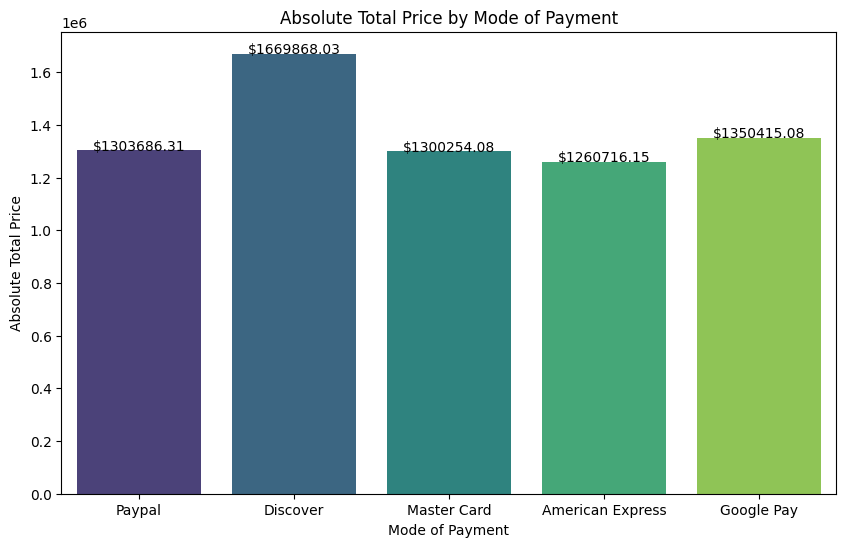

In [355]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=payment.index, y=payment.values, palette='viridis')
bar_plot.set_xlabel('Mode of Payment')
bar_plot.set_ylabel('Absolute Total Price')
bar_plot.set_title('Absolute Total Price by Mode of Payment')

# Add values on top of each bar
for i, v in enumerate(payment.values):
    plt.text(i, v + 50, f'${v:.2f}', ha='center')
plt.show()


As seen from the sample data generated for mode of payment, there doesn't seem to be any relation between the order amount and payment method

**7. Customer Behavior**

7.1 How long, on average, do customers remain active (between their first and last
purchase)?

In [ ]:
customer_activity = customer.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])

# Calculate the duration of activity for each customer
customer_activity['Duration'] = customer_activity['max'] - customer_activity['min']

# Calculate the average duration across all customers
average_duration = customer_activity['Duration'].mean()

print(f"Average Duration of Customer Activity: {average_duration}")

Average Duration of Customer Activity: 133 days 17:25:29.204025618


7.2 customer segments based on their purchase behavior

The customer segments based on purchase behavior are

*   High-Value and Recently Active Customers
*   Regular but Less Recent Customers
*   High-Frequency but Lower Monetary Value
*   Infrequent and Low-Value Customers





**8. RETURNS AND REFUNDS**

8.1 What is the percentage of orders that have experienced returns or refunds?

In [ ]:
neg_quant= customer[customer['Quantity']<0]
print("percentage of orders that have experienced returns or refunds: ", len(neg_quant)/len(customer)*100, "%")

percentage of orders that have experienced returns or refunds:  2.188880340388714 %


8.2 Is there a correlation between the product category and the likelihood of returns?

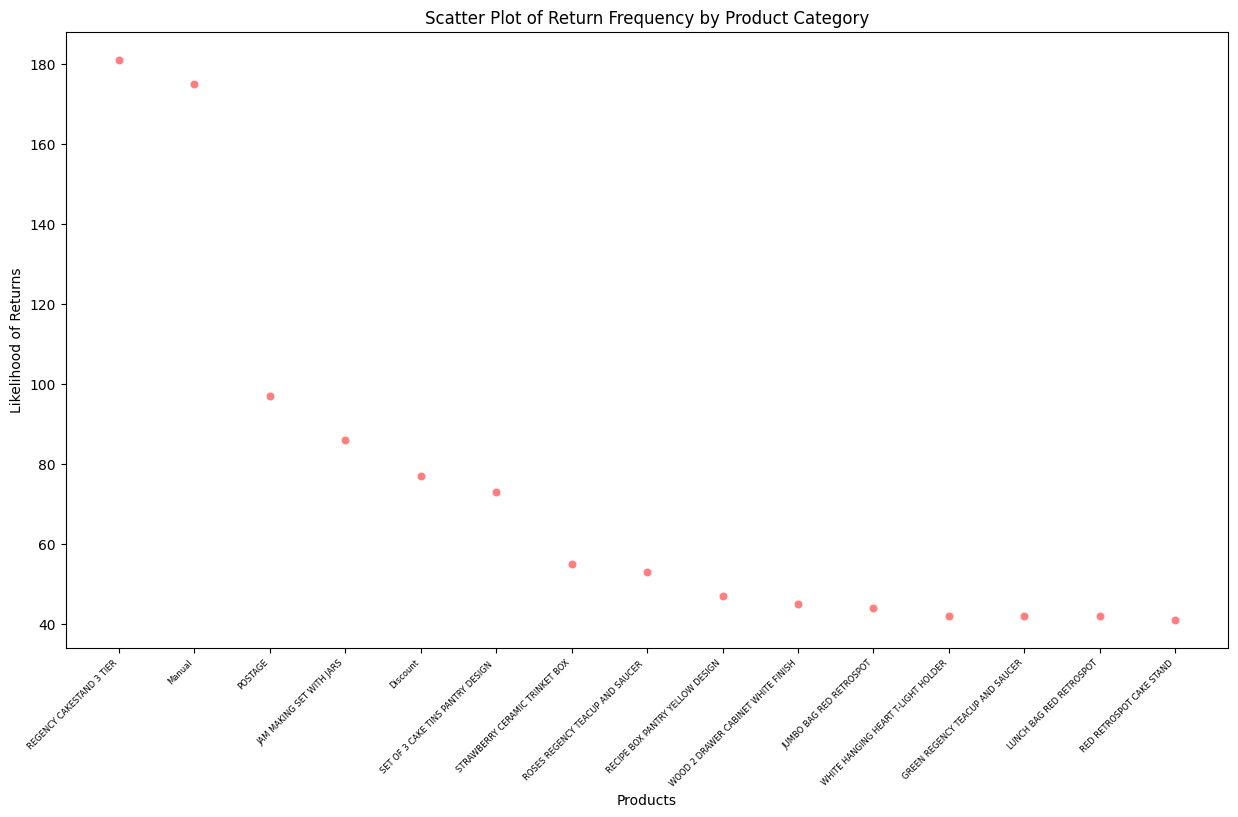

In [ ]:
neg_df = neg_quant.groupby('Description').size().reset_index()
neg_df.columns = ['Description', 'Return Frequency']
neg_df = neg_df.sort_values(by='Return Frequency', ascending=False).head(15)



plt.figure(figsize=(15, 8))
sns.scatterplot(x='Description', y='Return Frequency', data=neg_df, alpha=0.5, color='red')
plt.xticks(rotation=45, ha='right', fontsize=6)

plt.xlabel('Products')
plt.ylabel('Likelihood of Returns')
plt.title('Scatter Plot of Return Frequency by Product Category')
plt.show()


**ARIMA For Customer Churn Prediction**

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
customer_tseries= customer.copy()

In [ ]:
customer['InvoiceDate'] = customer['InvoiceDate'].apply(lambda x: x.date())
print(customer['InvoiceDate'])

0         2010-12-01
1         2010-12-01
2         2010-12-01
3         2010-12-01
4         2010-12-01
             ...    
541904    2011-12-09
541905    2011-12-09
541906    2011-12-09
541907    2011-12-09
541908    2011-12-09
Name: InvoiceDate, Length: 406829, dtype: object
